# Классификация движения фехтовальщика

# Исходные данные и библиотеки

In [6]:
# путь к папке fencing_signals
way_folder = 'fencing_signals/'

# пусть к папкам с записями для каждого участника
exp = [
    'Cherkasova_20_1/', 
    'Cherkasova_20_2/', 
    'Sugkoeva_17/', 
    'Zushko_18/'
      ]

exp_endurance = ['Cherkasova_20_3/']

#частота дискритизации устройства
fs = 100

#части тела, к которым закреплены датчики
body_part = ["передней руке", "груди", "передней ноге", "задней ноге"]

# сохранение графиков
save = True

In [7]:
# Словарь настроек для каждого фехтовальщика и типа движения
settings = {
    'Cherkasova_20_1/': {
        'Arm/': {
            'start_trim': 152,
            'end_trim': 2550,
            'height_threshold': 95,
            'prominence_value': 90,
            'distance_value': 50
        },
        'Step/': {
            'start_trim': 303,
            'end_trim': 3816,
            'height_threshold': 400,
            'prominence_value': 200,
            'distance_value': 70
        },
        'Lunge/': {
            'start_trim': 485,
            'end_trim': 5066,
            'height_threshold': 430,
            'prominence_value': 400,
            'distance_value': 90
        }
    },
    'Cherkasova_20_2/': {
        'Arm/': {
            'start_trim': 197,
            'end_trim': 4309,
            'height_threshold': 95,
            'prominence_value': 90,
            'distance_value': 50
        },
        'Step/': {
            'start_trim': 152,
            'end_trim': 4028,
            'height_threshold': 376,
            'prominence_value': 250,
            'distance_value': 65
        },
        'Lunge/': {
            'start_trim': 212,
            'end_trim': 4307,
            'height_threshold': 750,
            'prominence_value': 400,
            'distance_value': 57
        }
    },
    'Sugkoeva_17/': {
        'Arm/': {
            'start_trim': 180,
            'end_trim': 5069,
            'height_threshold': 90,
            'prominence_value': 90,
            'distance_value': 50
        },
        'Step/': {
            'start_trim': 147,
            'end_trim': 5372,
            'height_threshold': 400,
            'prominence_value': 250,
            'distance_value': 45
        },
        'Lunge/': {
            'start_trim': 284,
            'end_trim': 5660,
            'height_threshold': 500,
            'prominence_value': 380,
            'distance_value': 65
        }
    },
    'Zushko_18/': {
        'Arm/': {
            'start_trim': 167,
            'end_trim': 3809,
            'height_threshold': 95,
            'prominence_value': 90,
            'distance_value': 50
        },
        'Step/': {
            'start_trim': 100,
            'end_trim': 4539,
            'height_threshold': 400,
            'prominence_value': 200,
            'distance_value': 70
        },
        'Lunge/': {
            'start_trim': 162,
            'end_trim': 4918,
            'height_threshold': 500,
            'prominence_value': 380,
            'distance_value': 65
        }
    },
    'Cherkasova_20_3/': {
        'Lunge/': [
            {  
                'height_threshold': 450,
                'prominence_value': 50,
                'distance_value': 68
            },
            {  
                'height_threshold': 450,
                'prominence_value': 200,
                'distance_value': 80
            }
        ]
    }
}

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import pandas as pd
import numpy as np
import os
import math
import warnings
warnings.filterwarnings('ignore')
from scipy.signal import find_peaks

# Используемые функции для клиссификации

In [10]:
def read_data(file_names, column_names, num):
    """Чтение записанных данных"""
    
    dfs = []
    for file_name, column_name in zip(file_names, column_names):
        df = pd.read_csv(file_name, header=None, delimiter="\t", decimal=",", comment=";", names=[column_name])
        df_rounded = df.round(2)
        dfs.append(df_rounded)
    
    dfs_concated = []
    for i in range(num):
        df = pd.concat([dfs[i], dfs[i + num], dfs[i + 2*num]], axis=1)
        dfs_concated.append(df)
    return dfs_concated
        

def creation_of_dfs(way_folder, experimental, folder, num):
    """Создание датафреймов с данными гироскопа по осям"""
    
    folder_path = f"{way_folder}{experimental}{folder}CSV_Export"
    file_names = ["Hyro Y_9.csv", "Hyro X_11.csv", "Hyro Z_16.csv", "Hyro X_17.csv", 
                  "Hyro X_8.csv", "Hyro Z_13.csv", "Hyro X_14.csv", "Hyro Z_19.csv",
                  "Hyro Z_10.csv", "Hyro Y_12.csv", "Hyro Y_15.csv", "Hyro Y_18.csv"]
    
    file_paths = [os.path.join(folder_path, file_name) for file_name in file_names]
    column_names = ["x", "x", "x", "x", "y", "y", "y", "y", "z", "z", "z", "z"]   
    dfs = read_data(file_paths, column_names, num)
    
    dfs[3]['x'] = dfs[3]['x'].apply(np.negative)
    dfs[2]['y'] = dfs[2]['y'].apply(np.negative)
    dfs[3]['y'] = dfs[3]['y'].apply(np.negative)
    return dfs  
    

def find_movement_peaks(dfs, move, num, params):
    """Поиск индексов начала и конца движения вперед и назад"""
    
    # Так как угол поворота руки и корпуса меньше, чем ног, 
    # то для точного определения начала движения с начала движения руки, удвоим все значения
    dfs[0]['vector'] *= 2
    dfs[1]['vector'] *= 2

    # Создание общего датафрейма со всеми векторами для датчиков
    combined_df = pd.concat(dfs[i]['vector'] for i in range(num))
    # Суммирование значений векторов для датчиков в каждый отсчет
    combined_df = combined_df.groupby(combined_df.index).agg('sum')
    
    # Получение параметров из словаря настроек
    height_threshold = params['height_threshold']
    prominence_value = params['prominence_value']
    distance_value = params['distance_value']

    # Нахождение пиков
    peaks, _ = find_peaks(combined_df, height=height_threshold, prominence=prominence_value, distance=distance_value)
    
    # Вычисление производной
    derivative = np.gradient(combined_df, combined_df.index)
    # Нахождение пиков производной
    positive_peaks, _ = find_peaks(derivative, distance=15)
    negative_peaks, _ = find_peaks(-derivative, distance=15)

    # Определение индексов начала и конца движений
    start_indices, end_indices = define_movement_bounds(peaks, derivative, distance_value, combined_df)

    # Разделение на движение вперед и назад по индексам
    df_forward_index, df_backward_index = separate_movements(start_indices, end_indices)

    return combined_df, start_indices, end_indices, positive_peaks, negative_peaks, derivative, peaks, df_forward_index, df_backward_index


def define_movement_bounds(peaks, derivative, distance_value, combined_df):
    """
    Вспомогательная функция
    Индексы начала и конца движения
    
    """
    
    midpoints = [(peaks[j - 1] + peaks[j]) // 2 for j in range(1, len(peaks))]
    start_indices = []
    end_indices = []
    window_size = [(peaks[j] - peaks[j - 1]) // 6 for j in range(1, len(peaks))]
    
    # Начало движения до первого пика
    first_peak_idx = peaks[0]
    search_start = max(0, first_peak_idx - np.median(window_size)*4)
    start_indices.insert(0, combined_df.index[int(search_start)])

    # Код поиска индексов начала и конца всех движений
    for n, midpoint in enumerate(midpoints):
        # Индекс серединной точки в исходном DataFrame
        midpoint_idx = combined_df.index.get_loc(midpoint)

        # Границы поиска в окрестности серединной точки
        search_start = max(0, midpoint_idx - window_size[n])
        search_end = min(len(combined_df) - 1, midpoint_idx + window_size[n])

        # Поиск индекса, где производная меняет знак с "+" на "-"
        for k in range(search_start + 1, search_end):
            if k < len(derivative) - 1 and derivative[k] < 0 and derivative[k - 1] >= 0:
                end_indices.append(combined_df.index[k]+10)
                break

        # Поиск индекса, где производная меняет знак с "-" на "+"
        for l in range(search_end - 1, search_start, -1):
            if l < len(derivative) - 1 and derivative[l] > 0 and derivative[l + 1] <= 0:
                start_indices.append(combined_df.index[l]-10)
                break

    # Конец движения после последнего пика
    last_peak_idx = peaks[-1]
    search_end = min(len(combined_df) - 1, last_peak_idx + np.median(window_size)*4)
    end_indices.append(combined_df.index[int(search_end)])

    return start_indices, end_indices


def separate_movements(start_indices, end_indices):
    """
    Вспомогательная функция
    Создание датафреймов с индексами движений, разделение всех движений на движения вперед и назад
    
    """
    
    # Индексы движения вперед и назад
    start_forward = start_indices[::2]
    end_forward = end_indices[::2]
    start_backward = start_indices[1::2]
    end_backward = end_indices[1::2]

    # Создание датафреймов с индексами для движений вперед и назад
    df_forward = pd.DataFrame({'start': start_forward, 'end': end_forward})
    df_backward = pd.DataFrame({'start': start_backward, 'end': end_backward})

    return df_forward, df_backward

       
     
def plot_dfs(way_folder, experimental, folder, dfs, part, body_part, row, column,
             start_indices = None, end_indices = None, save = False):
    """Вывод изображений"""
    
    fig = plt.figure(figsize=(20, 10))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(row, column, i + 1)
        ax.plot(df['t'], df['x'], color='red', label='X')
        ax.plot(df['t'], df['y'], color='blue', label='Y')
        ax.plot(df['t'], df['z'], color='darkgreen', label='Z')
        if start_indices is not None and end_indices is not None:
            for start, end in zip(start_indices, end_indices):
                plt.fill_betweenx(y=[-(df['vector'].max()), df['vector'].max()], 
                                  x1=df['t'][start], x2=df['t'][end], 
                                  color='lightgray', alpha=0.5)
            plt.vlines(x=df['t'][start_indices], ymin=-(df['vector'].max()), ymax=df['vector'].max(), color='gray')       
            plt.vlines(x=df['t'][end_indices], ymin=-(df['vector'].max()), ymax=df['vector'].max(), color='gray')
        ax.set_title(f'Сенсор закреплен на {body_part[i]}', fontsize=16)
        ax.set_ylabel('Угол, град', fontsize=12)
        ax.grid(which='major', linewidth=0.5, linestyle=':', color='k')
        ax.set_xlabel('Время, c', fontsize=12)
        ax.autoscale(enable=True, axis='both')
        plt.legend()
    fig.suptitle(f'Данные гироскопа. Движение: {part}', fontsize=20)
    plt.tight_layout()
    if save == True:
        plt.savefig(f'{way_folder}{experimental}{folder}/{part}.png', dpi=400, bbox_inches='tight')
    plt.show()
    plt.close()
    

def plot_peaks(way_folder, experimental, folder, combined_df, start_indices, 
               end_indices, positive_peaks, negative_peaks, derivative, peaks, 
               fencing_move, num, save = False):
    """Визуализация пиков"""
    
    fig = plt.figure(figsize=(10, 4))
    plt.plot(combined_df.index, combined_df, color='grey', label = f'Сумма векторов сигнала с {num} датчиков') # сигнал по модулю с 4 датчиков
    for start, end in zip(start_indices, end_indices):
        plt.fill_betweenx(y=[combined_df.min(), combined_df.max()],
                          x1=combined_df.index[start], x2=combined_df.index[end], color='lightgray', alpha=0.5)
    plt.vlines(x=combined_df.index[start_indices], ymin=combined_df.min(), ymax=combined_df.max(), color='green')       
    plt.vlines(x=combined_df.index[end_indices], ymin=combined_df.min(), ymax=combined_df.max(), color='green')       
    plt.plot(combined_df.index[positive_peaks], derivative[positive_peaks], color = 'orange', label = 'Производная')
    plt.plot(combined_df.index[negative_peaks], derivative[negative_peaks], color = 'orange')
    plt.plot(peaks, combined_df[peaks], "x", ms=10, mew=2, label = 'Пик')
    plt.ylabel('Угол, град', fontsize=10)
    plt.xlabel('Индексы', fontsize=10)
    plt.grid(which='major', linewidth=0.5, linestyle=':', color='k')
    plt.autoscale(enable=True, axis='both')
    plt.legend(fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.title(f'Данные гироскопа. Движение: {fencing_move}', fontsize=12)
    plt.tight_layout()
    if save == True:
        plt.savefig(f'{way_folder}{experimental}{folder}/{fencing_move}.png', dpi=400, bbox_inches='tight')
    plt.show()
    plt.close()
    

def movement(dfs, start, end):
    """Разделение сигнала на отдельные движения"""
    
    movement_dfs = []
    for df in dfs:
        movement_dfs.append(df[['x', 'y', 'z', 't']][start:end])
    return movement_dfs


def features(dfs, part, body_part, experimental, n = None):
    """Определение характеристик и вывод их в отдельный датафрейм"""

    # Словарь для перевода названий статистик
    translation_dict = {
        'count': 'Отсчеты',
        'mean': 'Среднее',
        'std': 'Стандартное отклонение',
        'min': 'Минимум',
        '25%': '25-й процентиль',
        '50%': 'Медиана',
        '75%': '75-й процентиль',
        'max': 'Максимум'
    }

    features_df = []
    for i, df in enumerate(dfs):
        
        # Создание датафрейма со статистическими характеристиками 
        #(не учитываем столбец t df.iloc[:, :3]), а функцию describe() переводим на русский язык
        feature_df = ((df.iloc[:, :3].describe()).round(1)).T.rename(columns=translation_dict)

        # Добавление маркеров
        feature_df['Движение'] = ' '.join(part.split()[:2])
        if n == None:
            feature_df['Номер'] = ' '.join(part.split()[2:])
        else:
            feature_df['Номер'] = feature_df.apply(lambda row: ' '.join(part.split()[2:]) + f"_{n}", axis=1)
        feature_df['Фехтовальщик'] = experimental
        feature_df['Датчик'] = body_part[i]
        
        features_df.append(feature_df)

    # Объединение датафреймов в один
    combined_df = pd.concat(features_df)
    
    # Метод pivot_table для преобразования combined_df
    pivot_df = combined_df.pivot_table(index=['Фехтовальщик', 'Движение', 'Номер', 'Датчик'], 
                                       columns=combined_df.index, 
                                       values=['Отсчеты', 
                                               'Среднее', 
                                               'Стандартное отклонение', 
                                               'Минимум', 
                                               '25-й процентиль', 
                                               'Медиана', 
                                               '75-й процентиль', 
                                               'Максимум']
                                      )


    pivot_df = pivot_df.drop(columns=[('Отсчеты', 'y'), ('Отсчеты', 'z')])
    return pivot_df


def evaluate_preds(true_values, train_true_values, pred_values, train_pred_values, labels, save=False):
    """Оценка качества модели и график предсказанные и фактические значения"""
    
    plt.figure(figsize=(8,5))
    plt.scatter(unique_movements, unique_movements, color='white', s = 1) 
    plt.xlabel('Предсказанные значения', fontsize=14)
    plt.ylabel('Фактические значения', fontsize=14)
    plt.title('Фактические и предсказанные значения', fontsize=16)
    plt.grid(which='major', linewidth=0.5, linestyle=':', color='k')
    plt.xticks(fontsize=10, rotation=45)
    plt.yticks(fontsize=10)
    plt.margins(x=0.1, y=0.1)
    
    # Подсчет количества точек с одинаковыми координатами для тренировочных данных
    point_counts_train = {}
    for x, y in zip(train_pred_values, train_true_values):
        point_counts_train[(x, y)] = point_counts_train.get((x, y), 0) + 1
    for (x, y), count in point_counts_train.items():
        size = 20 * count
        plt.scatter(x, y, color='red', s=size)
        offset = np.sqrt(size) / 4
        plt.annotate(f' ({count})', xy=(x, y), xytext=(offset, -offset),
                     textcoords='offset points', fontsize=8, color='red', ha='left', va='top')
    
    # Подсчет количества точек с одинаковыми координатами для тестовых данных
    point_counts_test = {}
    for x, y in zip(pred_values, true_values):
        point_counts_test[(x, y)] = point_counts_test.get((x, y), 0) + 1
    for (x, y), count in point_counts_test.items():
        size = 20 * count
        plt.scatter(x, y, color='green', s=size)
        offset = np.sqrt(size) / 2
        plt.annotate(f' {count}', xy=(x, y), xytext=(offset, offset),
                     textcoords='offset points', fontsize=8, color='green')
    
    rect = patches.FancyBboxPatch((0.15, 0.705), 0.27, 0.095, 
                                  boxstyle="round,pad=0.01", 
                                  facecolor='whitesmoke', alpha=0.5,
                                  edgecolor='black', 
                                  transform=plt.gcf().transFigure)
    plt.gca().add_patch(rect)
    plt.annotate('Количество точек:', 
                 xy=(0.05, 0.95), xytext=(0.025, 0.875), xycoords='axes fraction', fontsize=10, color='black')
    plt.annotate('• 1 - тестовая выборка', 
                 xy=(0.05, 0.95), xytext=(0.025, 0.825), xycoords='axes fraction', fontsize=10, color='green')
    plt.annotate('• (1) - тренировочная выборка', 
                 xy=(0.05, 0.95), xytext=(0.025, 0.775), xycoords='axes fraction', fontsize=10, color='red')
    
    if save == True:
        plt.savefig(f'Фактические и предсказанные значения {len(train_true_values)}.png', dpi=400, bbox_inches='tight')
    plt.show()

# Обработка и анализ данных для классификации

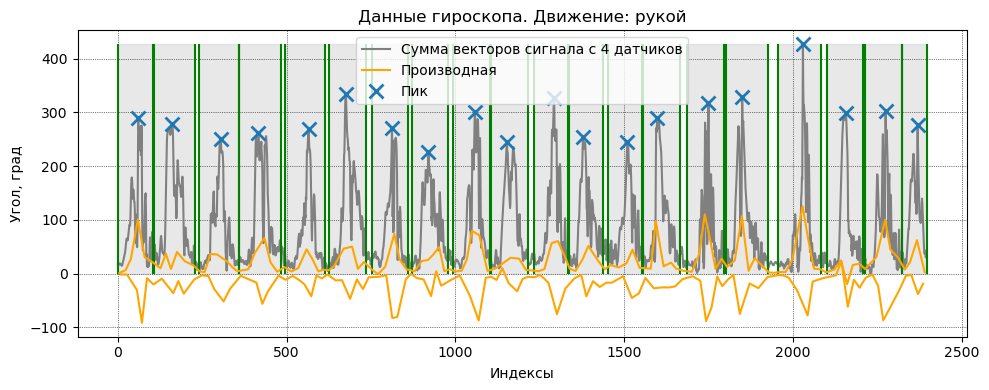

Количество пиков: 20


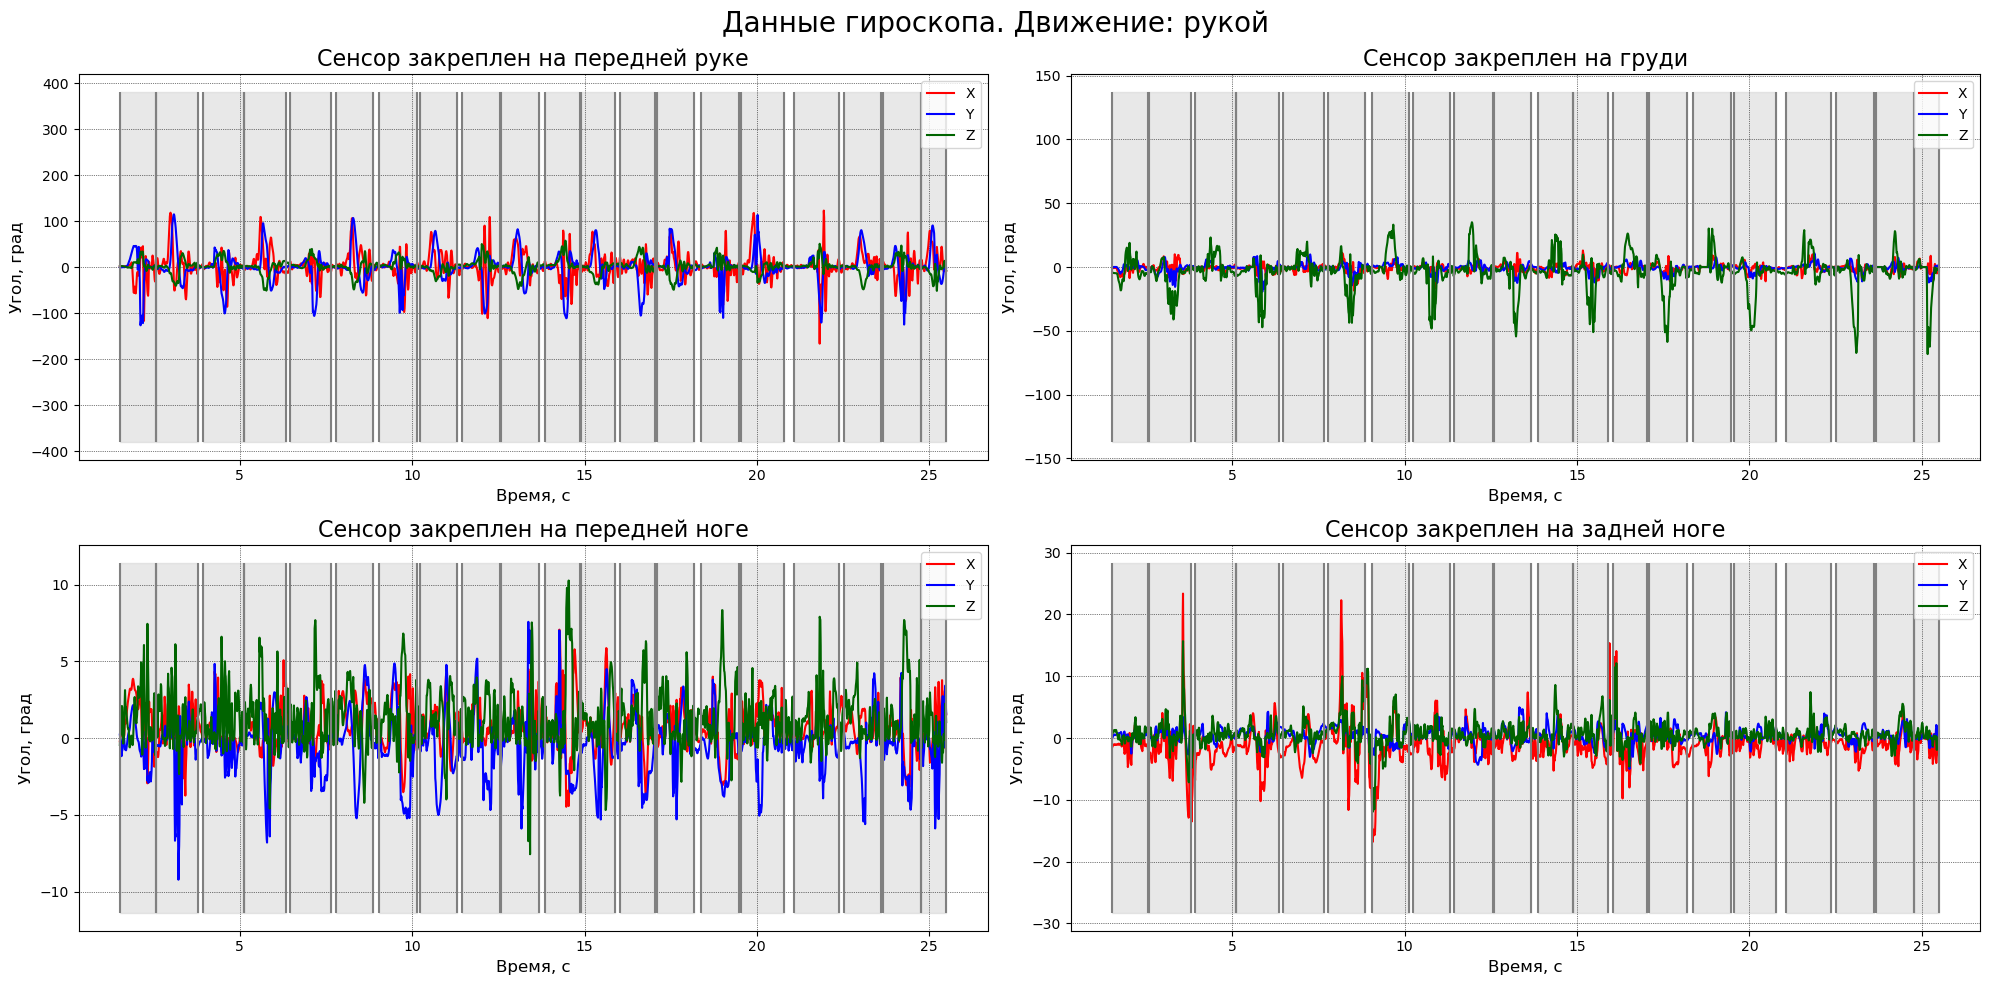

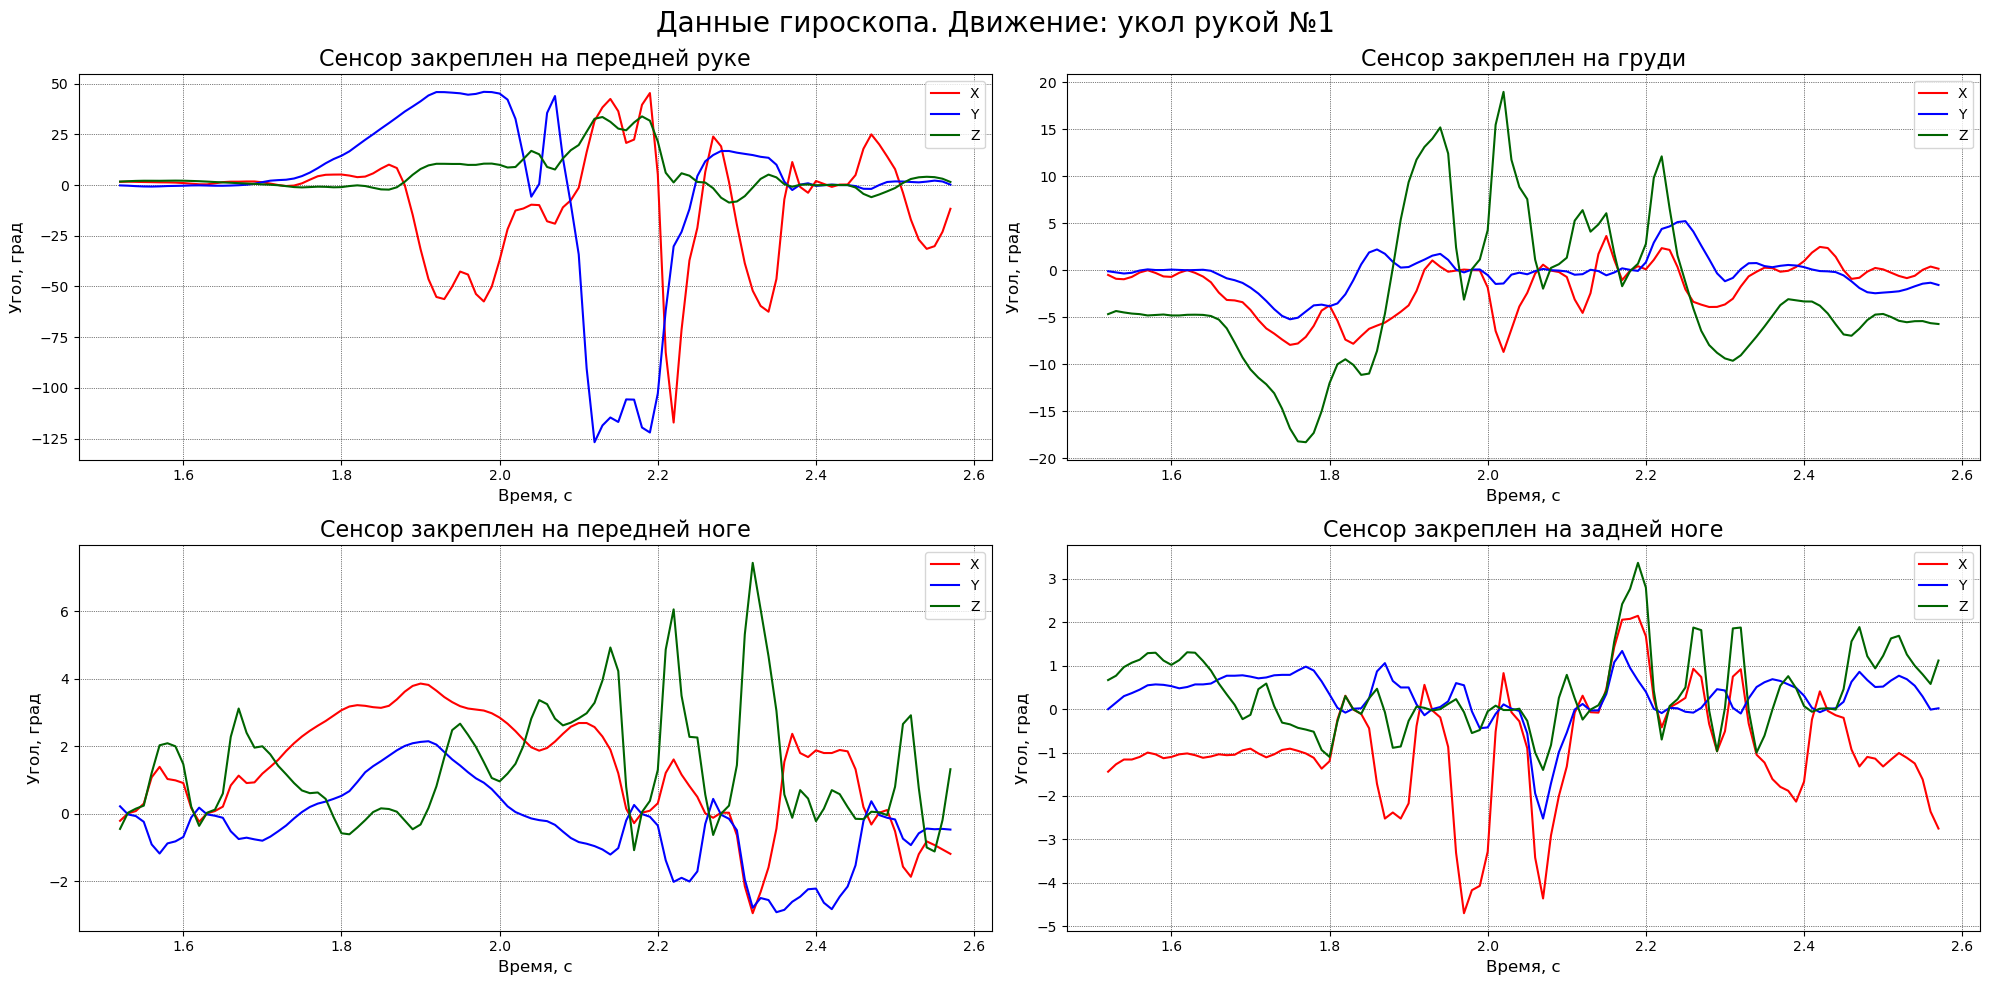

In [83]:
# название папок с движениями
moves = ['Arm/', 'Step/', 'Lunge/']
#выполняемые действия
fencing_move = ['рукой', 'шагом', 'выпадом']
num = 4

ways = ['укол', 'закрытие']
all_movement_dfs = []
all_params = []
peaks_executed = False
action_executed = False
row = 2
column = 2
import numpy as np
import pandas as pd
from scipy.signal import find_peaks


for experimental in exp:
    for i, move in enumerate(moves):
        dfs = creation_of_dfs(way_folder, experimental, move, num)

        # Создание отсчета времени, используя частоту дискретизации устройства
        # Создание вектора по евклидовой норме
        t = np.arange(len(dfs[0]['x'])) / fs
        for df in dfs:
            df['t'] = t
            df['vector'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
        
        # Обрезка сигнала
        if move in settings.get(experimental, {}):
            setting_params = settings[experimental][move]
            start_trim = setting_params['start_trim']
            end_trim = setting_params['end_trim'] if setting_params['end_trim'] is not None else len(dfs[0])
            for b, df in enumerate(dfs):
                dfs[b] = df.iloc[start_trim:end_trim].reset_index(drop=True)
                 
        # Поиск индексов начала и конца одного движения, подсчет пиков, вывод графиков сигнала 
        combined_df, start_indices, end_indices, positive_peaks, negative_peaks, derivative, peaks, df_forward_ind, df_backward_ind = find_movement_peaks(dfs, move, num, setting_params)
        if not peaks_executed:
            plot_peaks(way_folder, experimental, move, combined_df, start_indices, end_indices, positive_peaks, negative_peaks, derivative, peaks, fencing_move[i], num, save = save)
            print('Количество пиков:', len(peaks))
            plot_dfs(way_folder, experimental, move, dfs, fencing_move[i], body_part, row, column, start_indices, end_indices, save = save)
            peaks_executed = True
            
        # Разделение сигнала на отдельные движения и подсчет параметров для характеристики сигнала
        for n, df in enumerate([df_forward_ind, df_backward_ind]):
            for a in range(len(df)):
                movement_dfs = movement(dfs, df['start'][a], df['end'][a])
                all_movement_dfs.append(movement_dfs)
                #Для примера. Вывод графика одного движения и данные датчиков к нему
                if not action_executed:
                    plot_dfs(way_folder, experimental, move, movement_dfs, f'{ways[n]} {fencing_move[i]} №{a+1}', body_part, row, column, save = save)
                    action_executed = True
                    
                params = features(movement_dfs, f'{ways[n]} {fencing_move[i]} {a+1}', body_part, experimental)
                all_params.append(params)
            
# Объединение датафреймов в один 
A = pd.concat(all_params)

### Общий датафрейм A содержит в себе данные о всех сделанных движениях во время исследования, а также их параметры

In [86]:
print('Количество параметров для 1 движения: ', 4*A.shape[1]-3)
A.head(8)

Количество параметров для 1 движения:  85


25-й процентиль            \
                                                              x    y    z   
Фехтовальщик     Движение   Номер Датчик                                    
Cherkasova_20_1/ укол рукой 1     груди                    -3.8 -1.3 -6.9   
                                  задней ноге              -1.3  0.0 -0.1   
                                  передней ноге             0.1 -0.9  0.1   
                                  передней руке           -19.4 -0.4 -0.4   
                            2     груди                    -0.7 -0.6 -4.4   
                                  задней ноге              -2.6 -0.1 -0.1   
                                  передней ноге            -0.2 -1.0  0.1   
                                  передней руке           -18.6 -2.4 -0.2   

                                                75-й процентиль              \
                                                              x     y     z   
Фехтовальщик     Движение   Номер Датчик                                      
Cherkasova_20_1/ укол рукой 1     груди                     0.0   0.3   1.1   
                                  задней ноге              -0.1   0.6   1.0   
                                  передней ноге             2.6   0.2   2.3   
                                  передней руке             4.8  15.8   8.9   
                            2     груди                     0.2   0.4   7.3   
                                  задней ноге              -1.1   1.0   0.9   
                                  передней ноге             0.6   0.0   2.0   
                                  передней руке             4.0   8.7  14.1   

                                                Максимум             Медиана  \
                                                       x     y     z       x   
Фехтовальщик     Движение   Номер Датчик                                       
Cherkasova_20_1/ укол рукой 1     груди              3.6   5.2  19.0    -0.7   
                                  задней ноге        2.2   1.3   3.4    -1.0   
                                  передней ноге      3.9   2.2   7.4     1.5   
                                  передней руке     45.3  45.9  33.8     0.6   
                            2     груди              3.8   6.0  23.2    -0.1   
                                  задней ноге        0.3   2.3   3.6    -1.8   
                                  передней ноге      4.3   4.8   6.6     0.0   
                                  передней руке     42.3  42.5  35.1    -0.3   

                                                 ... Минимум               \
                                                 ...       x      y     z   
Фехтовальщик     Движение   Номер Датчик         ...                        
Cherkasova_20_1/ укол рукой 1     груди          ...    -8.7   -5.2 -18.3   
                                  задней ноге    ...    -4.7   -2.5  -1.4   
                                  передней ноге  ...    -3.0   -2.9  -1.1   
                                  передней руке  ...  -117.0 -126.7  -8.6   
                            2     груди          ...    -4.6   -2.1 -10.9   
                                  задней ноге    ...    -6.9   -1.5  -1.8   
                                  передней ноге  ...    -1.0   -2.6  -1.0   
                                  передней руке  ...   -86.6 -100.9 -12.4   

                                                Отсчеты Среднее            \
                                                      x       x    y    z   
Фехтовальщик     Движение   Номер Датчик                                    
Cherkasova_20_1/ укол рукой 1     груди           106.0    -1.8 -0.4 -2.8   
                                  задней ноге     106.0    -0.9  0.3  0.4   
                                  передней ноге   106.0     1.3 -0.4  1.4   
                                  передней руке   106.0    -8.3 -1.5  5.2   
                            2     груди           120.0    -0.

### Классы движений

In [88]:
unique_movements = list(A.index.get_level_values('Движение').unique())
unique_movements

['укол рукой',
 'закрытие рукой',
 'укол шагом',
 'закрытие шагом',
 'укол выпадом',
 'закрытие выпадом']

In [89]:
All_signs = A.reset_index().pivot_table(index=['Фехтовальщик', 'Движение', 'Номер'], columns=['Датчик'])
All_signs.columns = [f'{col[0]}_{col[1]}_{col[2]}' for col in All_signs.columns]
All_signs.reset_index(inplace=True)
All_signs = All_signs.drop(['Фехтовальщик','Номер'], axis = 1)
print('Количество движений: ', len(All_signs))

Количество движений:  410


# Подготовка данных к решению задачи классификации с учителем 

In [91]:
y = All_signs['Движение'] # Целевая переменная
X = All_signs.drop('Движение', axis = 1) # Матрица признаков

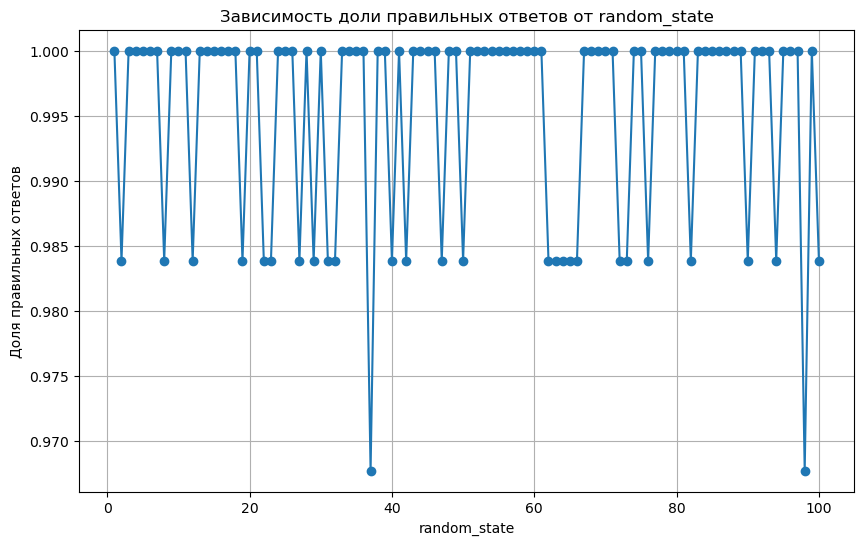

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

accuracies = []
for random_state in range(1, 101):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=random_state)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Отрисовка графика
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), accuracies, marker='o')
plt.title('Зависимость доли правильных ответов от random_state')
plt.xlabel('random_state')
plt.ylabel('Доля правильных ответов')
plt.grid(True)
if save == True:
    plt.savefig(f'Зависимость доли правильных ответов от random state.png', dpi=400, bbox_inches='tight')
plt.show()

max_random_state = accuracies.index(max(accuracies))+ 1

### Рандомизация выборки и разделение на тренировочную и тестовую выборки

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=max_random_state)

### Стандартизация признаков

In [96]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Решение задачи классификации методом логистической регрессии

In [98]:
# Создание модели логистической регрессии
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Обучение модели на обучающей выборке
lr.fit(X_train, y_train)

# Прогнозирование классов для тестовых данных
y_pred = lr.predict(X_test)

# Прогнозирование классов для тренировочных данных
y_train_pred = lr.predict(X_train)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Доля правильных ответов модели: {accuracy:.2f}')

Доля правильных ответов модели: 1.00


In [99]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=2))

                  precision    recall  f1-score   support

закрытие выпадом       1.00      1.00      1.00        16
  закрытие рукой       1.00      1.00      1.00        19
  закрытие шагом       1.00      1.00      1.00        14
    укол выпадом       1.00      1.00      1.00        11
      укол рукой       1.00      1.00      1.00         8
      укол шагом       1.00      1.00      1.00        14

        accuracy                           1.00        82
       macro avg       1.00      1.00      1.00        82
    weighted avg       1.00      1.00      1.00        82



In [100]:
check_test = pd.DataFrame({
    'Фактическое': y_test,
    'Предсказанное': y_pred.flatten(),
})

check_test.sample(10)

Фактическое     Предсказанное
106    закрытие шагом    закрытие шагом
18     закрытие рукой    закрытие рукой
370        укол рукой        укол рукой
312    закрытие рукой    закрытие рукой
325    закрытие рукой    закрытие рукой
214    закрытие шагом    закрытие шагом
271        укол рукой        укол рукой
6    закрытие выпадом  закрытие выпадом
408        укол шагом        укол шагом
230    закрытие шагом    закрытие шагом

## График сравнения фактических и предсказанных значений

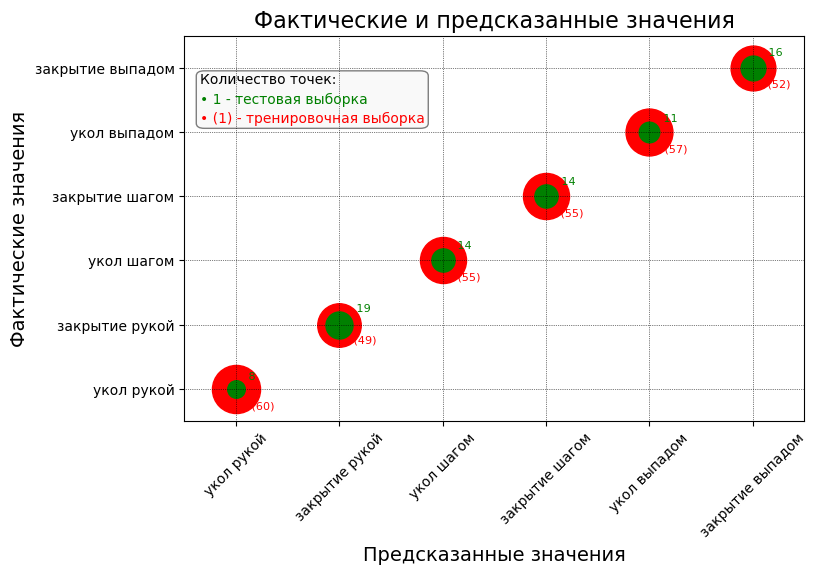

In [102]:
evaluate_preds(y_test, y_train, y_pred, y_train_pred, unique_movements, save = save)

# Решение задачи классификации методом случайного леса

In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Диапазон количества деревьев для тестирования
n_estimators_range = range(1, 13)

# Список для хранения средних точностей
mean_accuracies = []

for n_estimators in n_estimators_range:
    # Создание модели случайного леса с заданным количеством деревьев
    rf = RandomForestClassifier(n_estimators=n_estimators)

    # Оценка модели с использованием кросс-валидации
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')

    # Вычисление средней точности и добавление ее в список
    mean_accuracy = np.mean(scores)
    mean_accuracies.append(mean_accuracy)
    print(f"Количество деревьев: {n_estimators}, Средняя точность: {mean_accuracy:.3f}")

# Выбор количества деревьев с лучшей средней точностью
best_n_estimators = n_estimators_range[np.argmax(mean_accuracies)]
print(f"Лучшее количество деревьев: {best_n_estimators}")

Количество деревьев: 1, Средняя точность: 0.872
Количество деревьев: 2, Средняя точность: 0.887
Количество деревьев: 3, Средняя точность: 0.933
Количество деревьев: 4, Средняя точность: 0.957
Количество деревьев: 5, Средняя точность: 0.957
Количество деревьев: 6, Средняя точность: 0.963
Количество деревьев: 7, Средняя точность: 0.985
Количество деревьев: 8, Средняя точность: 0.976
Количество деревьев: 9, Средняя точность: 0.979
Количество деревьев: 10, Средняя точность: 0.982
Количество деревьев: 11, Средняя точность: 0.991
Количество деревьев: 12, Средняя точность: 0.988
Лучшее количество деревьев: 11


In [105]:
# Создание модели случайного леса
rf = RandomForestClassifier(n_estimators=best_n_estimators) 
# Обучение модели на обучающей выборке
rf.fit(X_train, y_train)

# Прогнозирование классов для тестовых данных
y_pred = rf.predict(X_test)

# Прогнозирование классов для тренировочных данных
y_train_pred = rf.predict(X_train)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Доля правильных ответов модели: {accuracy:.2f}')

Доля правильных ответов модели: 1.00


In [106]:
print(classification_report(y_test, y_pred, digits=2))

                  precision    recall  f1-score   support

закрытие выпадом       1.00      1.00      1.00        16
  закрытие рукой       1.00      1.00      1.00        19
  закрытие шагом       1.00      1.00      1.00        14
    укол выпадом       1.00      1.00      1.00        11
      укол рукой       1.00      1.00      1.00         8
      укол шагом       1.00      1.00      1.00        14

        accuracy                           1.00        82
       macro avg       1.00      1.00      1.00        82
    weighted avg       1.00      1.00      1.00        82



In [107]:
check_test = pd.DataFrame({
    'Фактическое': y_test,
    'Предсказанное': y_pred.flatten(),
})

check_test.sample(10)

Фактическое   Предсказанное
260      укол рукой      укол рукой
122    укол выпадом    укол выпадом
353    укол выпадом    укол выпадом
406      укол шагом      укол шагом
249    укол выпадом    укол выпадом
230  закрытие шагом  закрытие шагом
312  закрытие рукой  закрытие рукой
85   закрытие рукой  закрытие рукой
106  закрытие шагом  закрытие шагом
214  закрытие шагом  закрытие шагом

## График сравнения фактических и предсказанных значений

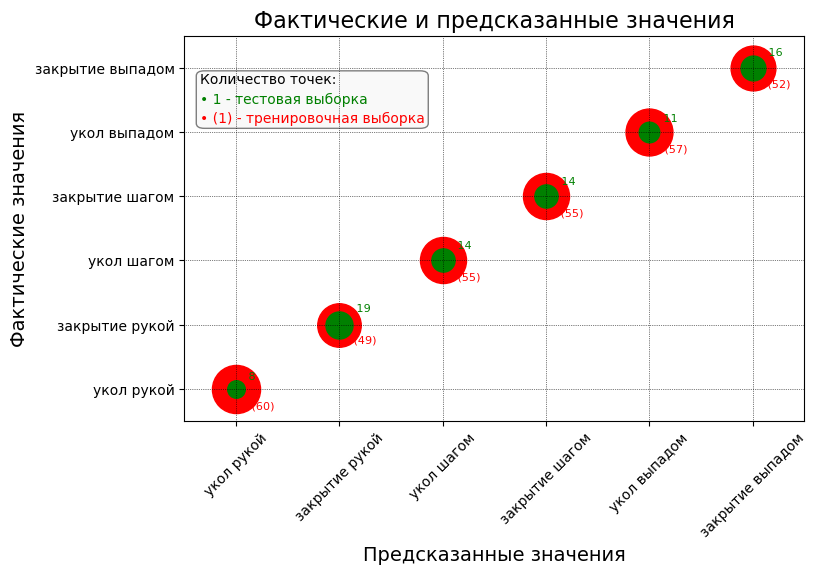

In [109]:
evaluate_preds(y_test, y_train, y_pred, y_train_pred, unique_movements, save = save)

# Анализ сигнала на усталость

In [111]:
def creation_of_dfs_endurance(way_folder, experimental, folder, num):
    """Создание датафреймов с данными гироскопа по осям"""
    
    folder_path = f"{way_folder}{experimental}{folder}CSV_Export"
    file_names = ["Hyro Y_1.csv", "Hyro X_3.csv", "Hyro Z_8.csv", 
                  "Hyro X_0.csv", "Hyro Z_5.csv", "Hyro X_6.csv",
                  "Hyro Z_2.csv", "Hyro Y_4.csv", "Hyro Y_7.csv"]
    
    file_paths = [os.path.join(folder_path, file_name) for file_name in file_names]
    column_names = ["x", "x", "x", "y", "y", "y", "z", "z", "z"]   
    dfs = read_data(file_paths, column_names, num)
    
    dfs[2]['y'] = dfs[2]['y'].apply(np.negative)
    return dfs


def creation_of_dfs_accel(way_folder, experimental, folder, num):
    """Создание датафреймов с данными по осям"""
    
    folder_path = f"{way_folder}{experimental}{folder}CSV_Export"
    file_names = ["Accelerometer Y_10.csv", 'Accelerometer X_12.csv', 'Accelerometer Z_17.csv',
                  "Accelerometer X_9.csv", 'Accelerometer Z_14.csv', 'Accelerometer X_15.csv',
                  "Accelerometer Z_11.csv", 'Accelerometer Y_13.csv', 'Accelerometer Y_16.csv']
    file_paths = [os.path.join(folder_path, file_name) for file_name in file_names]
    column_names = ["x", "x", "x", "y", "y", "y", "z", "z", "z"]
      
    dfs = read_data(file_paths, column_names, num)
    dfs[2]['y'] = dfs[2]['y'].apply(np.negative)
    return dfs


def split_dataframe(dfs):
    '''Разделение всего сигнала на два датафрейма, соответствующих движениям 1 и 3 подхода'''
    
    # Индексы для разделения данных
    split_index1 = 6500
    split_index2 = 12300
    split_index3 = 83530
    split_index4 = 89600

    dfs_1 = []
    dfs_2 = []
    for df in dfs:
        dfs_1.append(df.iloc[split_index1:split_index2])
        dfs_2.append(df.iloc[split_index3:split_index4])
    for df in dfs_1:
        df.reset_index(drop=True, inplace=True)
    for df in dfs_2:
        df.reset_index(drop=True, inplace=True)

    return dfs_1, dfs_2


def analyze_fencing_data(dfs_1, dfs_2, way_folder, experimental, move, fencing_move, body_part, row, column, num, setting_params, save=False):
    '''Разделение общего датафрейма на отдельные движения, подсчет параметров сигналов'''
    
    all_movement_dfs_forvard = []
    all_movement_dfs_backward = []
    all_movement_dfs = []
    all_params_endurance = []
    action_executed = False

    # Данные для сигнала 1 подхода
    combined_df_1, start_indices_1, end_indices_1, positive_peaks_1, negative_peaks_1, derivative_1, peaks_1, df_forward_ind_1, df_backward_ind_1 = find_movement_peaks(dfs_1, move, num, setting_params[0])
    print('Количество пиков:', len(peaks_1))
    plot_dfs_accel(way_folder, experimental, move, dfs_1, fencing_move, body_part, row, column, 'подход №1', start_indices_1, end_indices_1, save=save)

    for n, df in enumerate([df_forward_ind_1, df_backward_ind_1]):
        for a in range(len(df)):
            movement_dfs_1 = movement(dfs_1, df['start'][a], df['end'][a])
            all_movement_dfs.append(movement_dfs_1)
            params_1 = features(movement_dfs_1, f'{ways[n]} {fencing_move} {a+1}', body_part, experimental, 1)
            all_params_endurance.append(params_1)
            
            # Создание датафрейма с выпадами вперед
            if n == 0:
                all_movement_dfs_forvard.append(movement_dfs_1)
            # Создание датафрейма с закрытиями выпада
            if n == 1:
                all_movement_dfs_backward.append(movement_dfs_1)

    # Данные для сигнала 2 подхода
    combined_df_2, start_indices_2, end_indices_2, positive_peaks_2, negative_peaks_2, derivative_2, peaks_2, df_forward_ind_2, df_backward_ind_2 = find_movement_peaks(dfs_2, move, num, setting_params[1])
    print('Количество пиков:', len(peaks_2))
    plot_dfs_accel(way_folder, experimental, move, dfs_2, fencing_move, body_part, row, column, 'подход №2', start_indices_2, end_indices_2, save=save)

    for n, df in enumerate([df_forward_ind_2, df_backward_ind_2]):
        for a in range(len(df)):
            movement_dfs_2 = movement(dfs_2, df['start'][a], df['end'][a])
            all_movement_dfs.append(movement_dfs_2)
            params_2 = features(movement_dfs_2, f'{ways[n]} {fencing_move} {a+1}', body_part, experimental, 3)
            all_params_endurance.append(params_2)
            
            # Создание датафрейма с выпадами вперед
            if n == 0:
                all_movement_dfs_forvard.append(movement_dfs_2)
            # Создание датафрейма с закрытиями выпада
            if n == 1:
                all_movement_dfs_backward.append(movement_dfs_2)
    
    return all_params_endurance, df_forward_ind_1, df_backward_ind_1, df_forward_ind_2, df_backward_ind_2, all_movement_dfs, all_movement_dfs_forvard, all_movement_dfs_backward


def plot_dfs_accel(way_folder, experimental, folder, dfs, part, body_part, row, column, j,
             start_indices = None, end_indices = None, save = False):
    """Вывод изображений"""
    
    fig = plt.figure(figsize=(20, 10))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(row, column, i + 1)
        ax.plot(df['t'], df['x'], color='red', label='X')
        ax.plot(df['t'], df['y'], color='blue', label='Y')
        ax.plot(df['t'], df['z'], color='darkgreen', label='Z')
        if start_indices is not None and end_indices is not None:
            for start, end in zip(start_indices, end_indices):
                plt.fill_betweenx(y=[-(df['vector'].max()), df['vector'].max()], 
                                  x1=df['t'][start], x2=df['t'][end], 
                                  color='lightgray', alpha=0.5)
            plt.vlines(x=df['t'][start_indices], ymin=-(df['vector'].max()), ymax=df['vector'].max(), color='gray')       
            plt.vlines(x=df['t'][end_indices], ymin=-(df['vector'].max()), ymax=df['vector'].max(), color='gray')
        ax.set_title(f'Сенсор закреплен на {body_part[i]}', fontsize=16)
        ax.set_ylabel('Ускорение, g', fontsize=12)
        ax.grid(which='major', linewidth=0.5, linestyle=':', color='k')
        ax.set_xlabel('Время, c', fontsize=12)
        ax.autoscale(enable=True, axis='both')
        plt.legend()
    fig.suptitle(f'Данные акселерометра. Движение: {part} {j}', fontsize=20)
    plt.tight_layout()
    if save == True:
        plt.savefig(f'{way_folder}{experimental}{folder}/{part}.png', dpi=400, bbox_inches='tight')
    plt.show()
    plt.close()

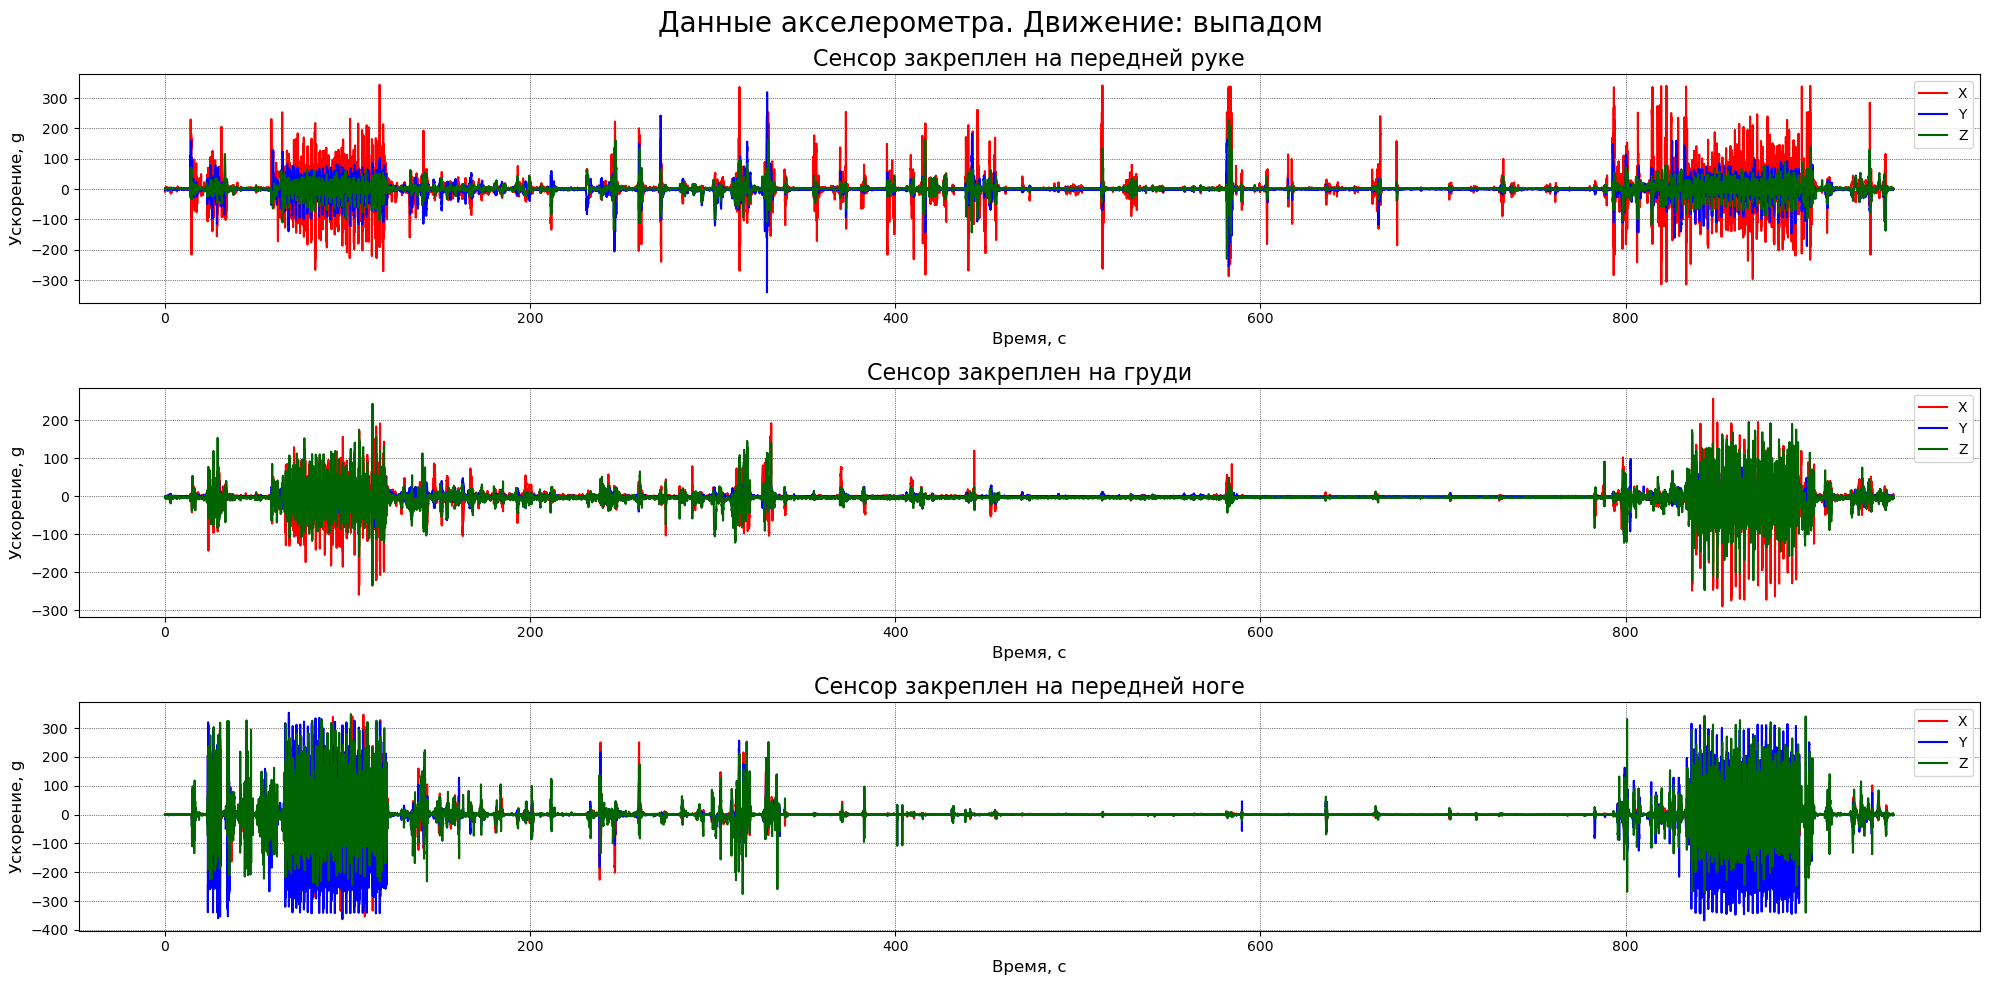

Количество пиков: 52


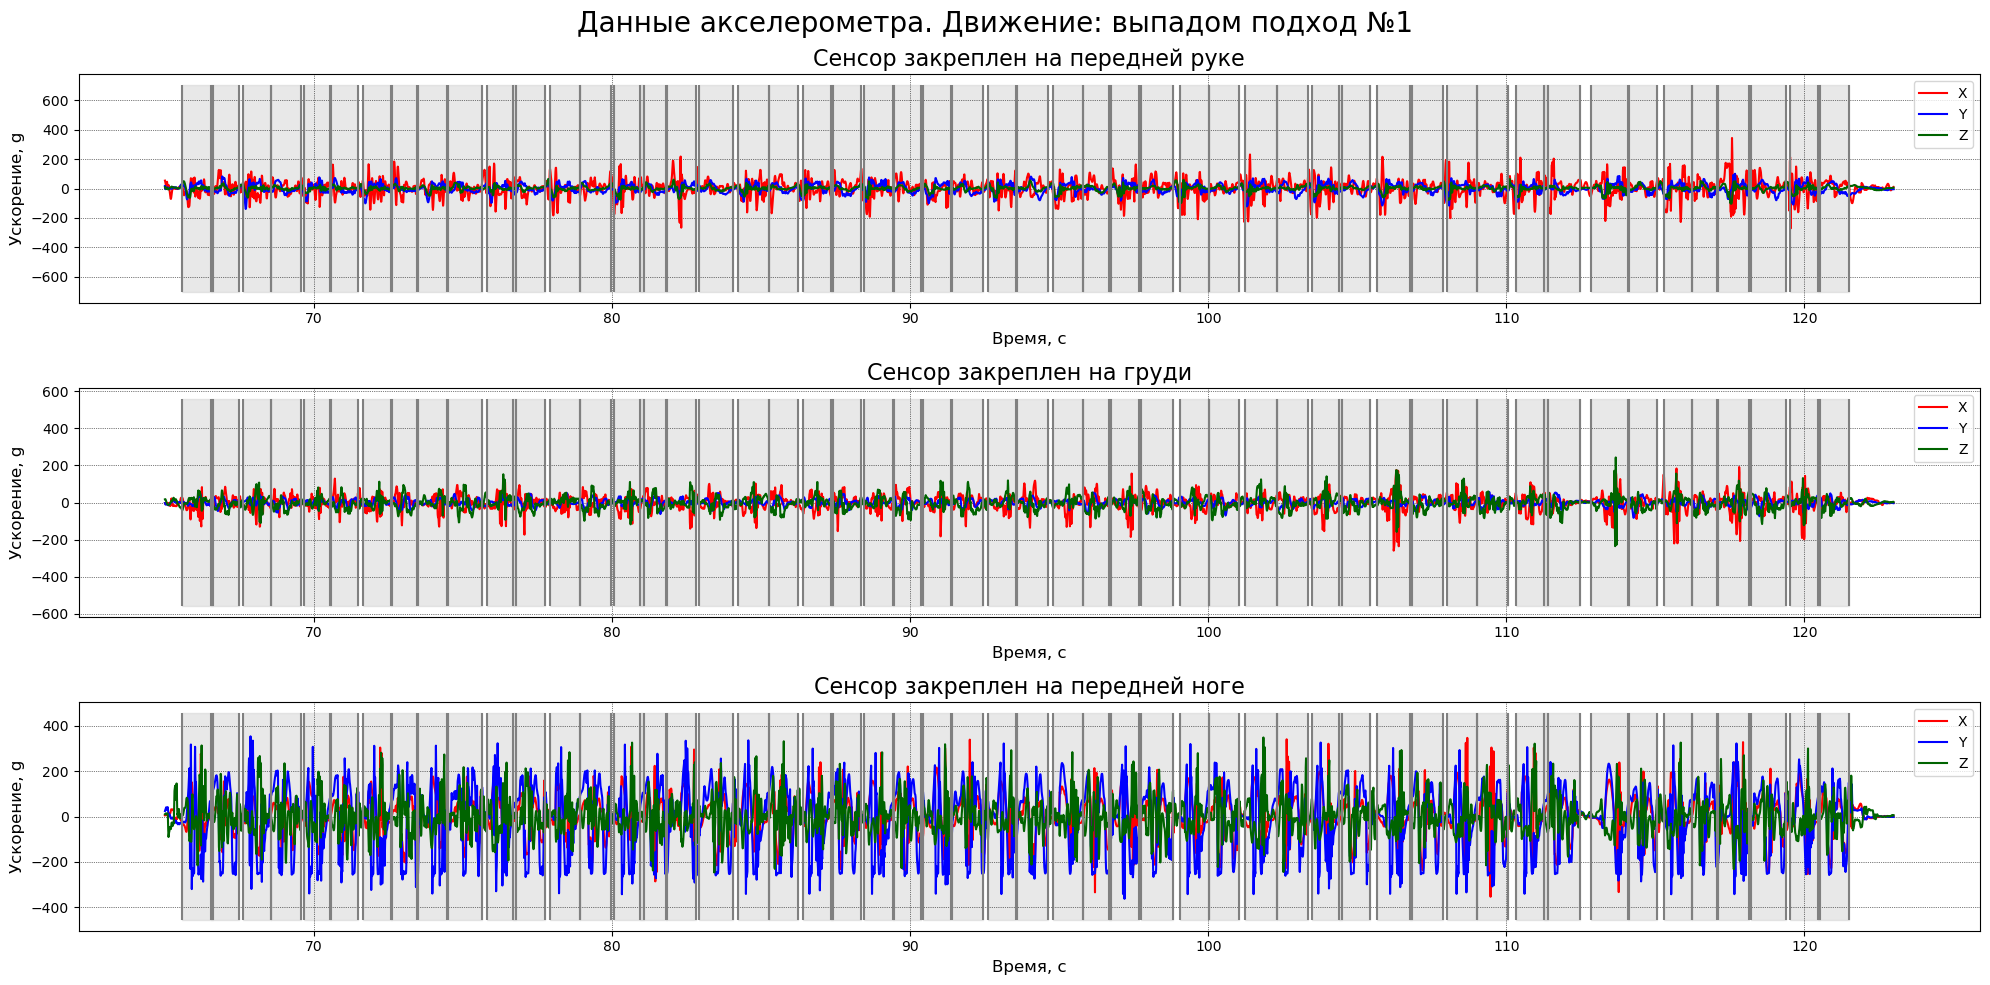

Количество пиков: 50


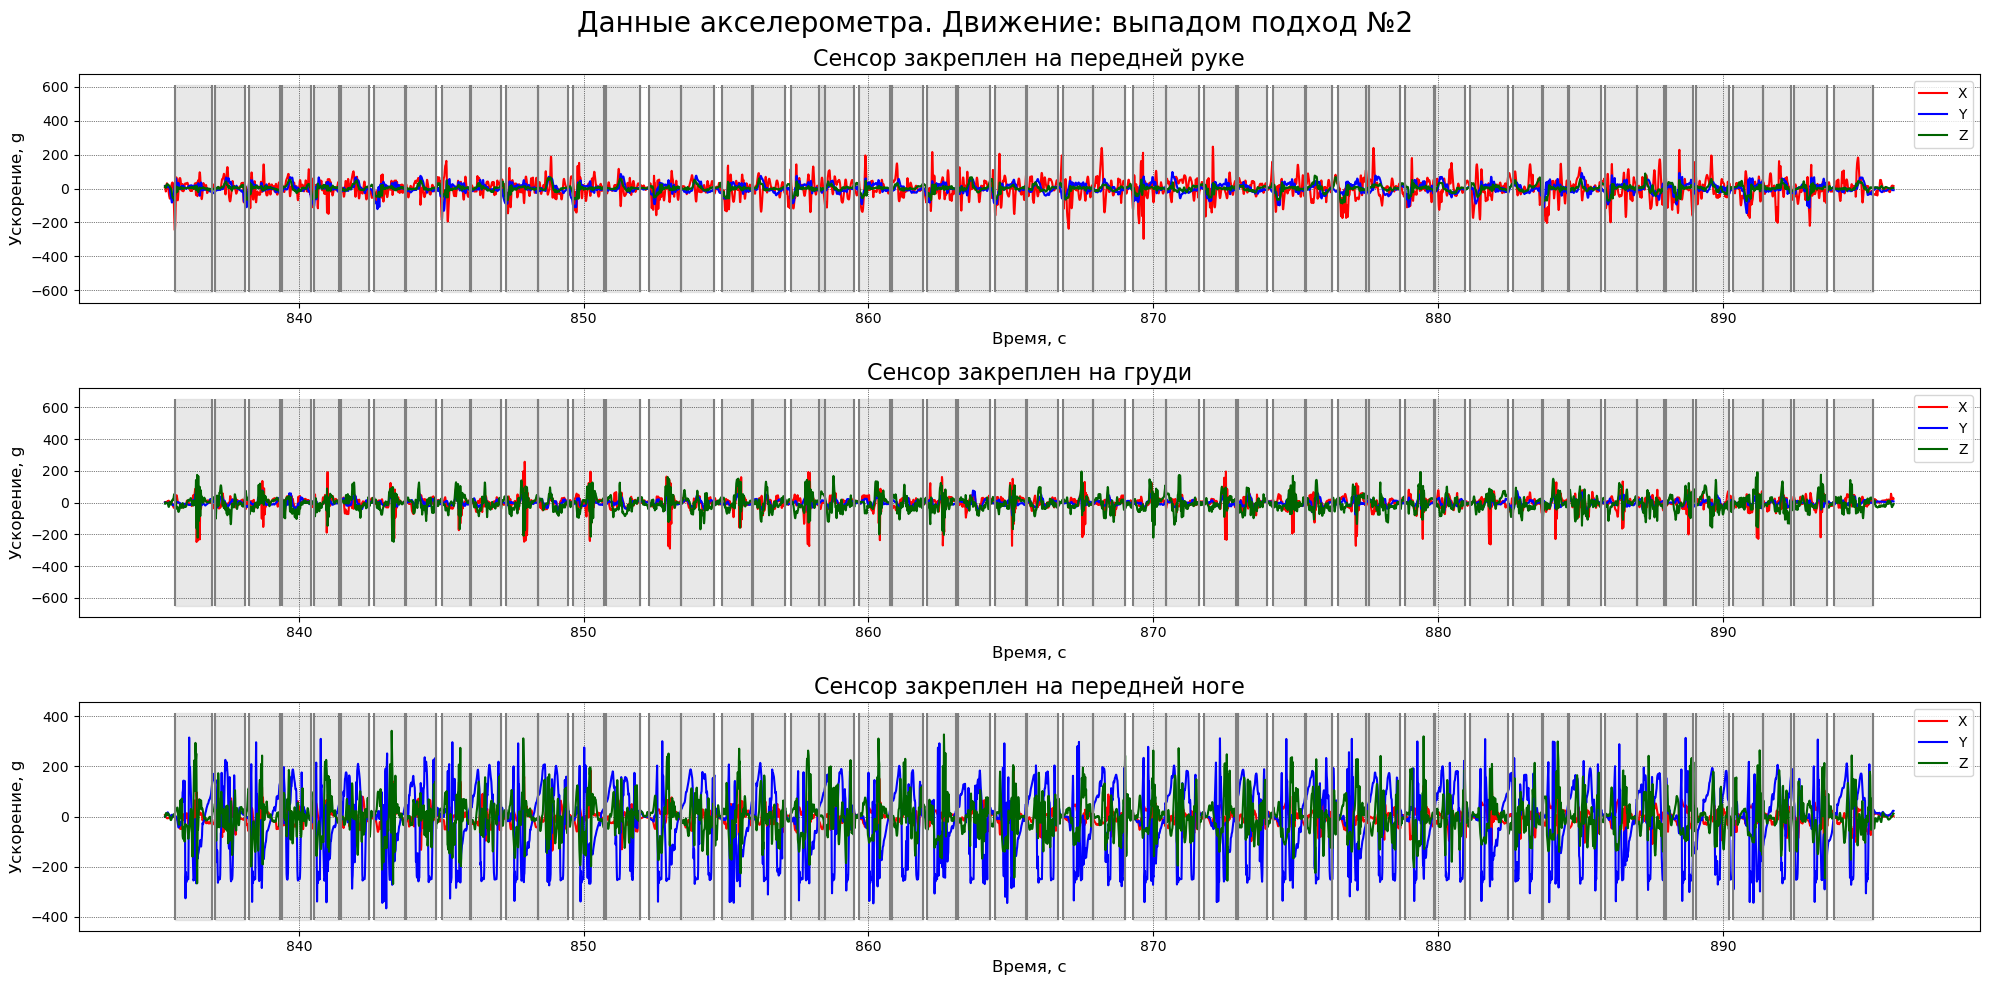

In [112]:
num = 3
row = 3
column = 1
move = 'Lunge/'
fencing_move = 'выпадом'
all_movement_dfs_accel = []
all_movement_dfs_accel_forvard = []
all_movement_dfs_accel_backward = []
A_endurance = []
                
for experimental in exp_endurance:
    dfs = creation_of_dfs_endurance(way_folder, experimental, move, num)
    t = np.arange(len(dfs[0]['x'])) / fs
    for df in dfs:
        df['t'] = t
        df['vector'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)

    dfs_accel = creation_of_dfs_accel(way_folder, experimental, move, num)
    for df in dfs_accel:
        df['t'] = t
        df['vector'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)

    if move in settings.get(experimental, {}):
        setting_params = settings[experimental][move]

    plot_dfs_accel(way_folder, experimental, move, dfs, fencing_move, body_part, row, column, j='', save=save)

    # Предобработка сигналов
    dfs_1, dfs_2 = split_dataframe(dfs)
    dfs_1_accel, dfs_2_accel = split_dataframe(dfs_accel)

    all_params_endurance, df_forward_ind_1, df_backward_ind_1, df_forward_ind_2, df_backward_ind_2, all_movement_dfs, all_movement_dfs_forvard, all_movement_dfs_backward = analyze_fencing_data(dfs_1, dfs_2, way_folder, experimental, move, fencing_move, body_part, row, column, num, setting_params, save=save)

    # Обработка сигнала акселерометра 1 подхода
    for n, df in enumerate([df_forward_ind_1, df_backward_ind_1]):
        for a in range(len(df)):
            movement_dfs_accel_1 = movement(dfs_1_accel, df['start'][a], df['end'][a])
            all_movement_dfs_accel.append(movement_dfs_accel_1)

            # Создание датафрейма с выпадами вперед
            if n == 0:
                all_movement_dfs_accel_forvard.append(movement_dfs_accel_1)
            # Создание датафрейма с закрытиями выпада
            if n == 1:
                all_movement_dfs_accel_backward.append(movement_dfs_accel_1)
            
    # Обработка сигнала акселерометра 3 подхода     
    for n, df in enumerate([df_forward_ind_2, df_backward_ind_2]):
        for a in range(len(df)):
            movement_dfs_accel_2 = movement(dfs_2_accel, df['start'][a], df['end'][a])
            all_movement_dfs_accel.append(movement_dfs_accel_2)

            # Создание датафрейма с выпадами вперед
            if n == 0:
                all_movement_dfs_accel_forvard.append(movement_dfs_accel_2)
            # Создание датафрейма с закрытиями выпада
            if n == 1:
                all_movement_dfs_accel_backward.append(movement_dfs_accel_2)

# Объединение датафреймов в один
A_endurance = pd.concat(all_params_endurance)

In [113]:
A_endurance

25-й процентиль         \
                                                                    x      y   
Фехтовальщик     Движение         Номер Датчик                                 
Cherkasova_20_3/ укол выпадом     1_1   груди                   -33.8  -12.7   
                                        передней ноге           -43.4 -204.2   
                                        передней руке           -37.6  -15.2   
                                  2_1   груди                   -28.0   -6.7   
                                        передней ноге           -29.0 -152.7   
...                                                               ...    ...   
                 закрытие выпадом 24_3  передней ноге           -20.4  -77.3   
                                        передней руке           -17.4  -13.2   
                                  25_3  груди                   -14.1   -9.3   
                                        передней ноге           -30.1    1.0   
                                        передней руке           -11.4  -14.9   

                                                            75-й процентиль  \
                                                          z               x   
Фехтовальщик     Движение         Номер Датчик                                
Cherkasova_20_3/ укол выпадом     1_1   груди          -3.7             7.9   
                                        передней ноге -29.9            69.9   
                                        передней руке  -5.3             4.0   
                                  2_1   груди         -15.2            11.5   
                                        передней ноге -47.0            42.4   
...                                                     ...             ...   
                 закрытие выпадом 24_3  передней ноге -24.7            15.5   
                                        передней руке  -1.6            42.9   
                                  25_3  груди         -35.6            13.4   
                                        передней ноге -40.0             6.6   
                                        передней руке  -3.6            34.4   

                                                                   Максимум  \
                                                           y     z        x   
Фехтовальщик     Движение         Номер Датчик                                
Cherkasova_20_3/ укол выпадом     1_1   груди            5.1  21.8     83.1   
                                        передней ноге   62.1  52.9    275.6   
                                        передней руке   26.3   8.6     74.9   
                                  2_1   груди           15.5  28.2     73.0   
                                        передней ноге   86.1  37.1    121.0   
...                                                      ...   ...      ...   
                 закрытие выпадом 24_3  передней ноге  101.1  23.8     79.2   
                                        передней руке    6.8  14.0    161.3   
                                  25_3  груди           14.2  17.6     53.3   
                                        передней ноге  114.0  29.4     62.4   
                                        передней руке    2.7   6.3    182.7   

                                                                    Медиана  \
                                                           y      z       x   
Фехтовальщик     Движение         Номер Датчик                                
Cherkasova_20_3/ укол выпадом     1_1   груди           45.0   65.2   -10.8   
                                        передней ноге  317.2  313.0   -12.7   
                                        передней руке   55.1   49.6   -15.4   
                                  2_1   груди           40.4  107.4   -12.0   
                                        передней ноге  353.3  266.5   -15.3   
...                                                      ...    ...     ...   
        

# Обучение модели логистической регрессии на данных 3 датчиков

## Удаление из изначальных данных сигнал с датчика на задней ноге

In [116]:
A_reset = A.reset_index(level='Датчик')
A_no_back_leg = A_reset[A_reset['Датчик'] != 'задней ноге']
All_signs_train_endurance = A_no_back_leg.reset_index().pivot_table(index=['Фехтовальщик', 'Движение', 'Номер'], columns=['Датчик'])
print('Количество параметров для 1 движения:', All_signs_train_endurance.shape[1])
All_signs_train_endurance.columns = [f'{col[0]}_{col[1]}_{col[2]}' for col in All_signs_train_endurance.columns]
All_signs_train_endurance.reset_index(inplace=True)
All_signs_train_endurance = All_signs_train_endurance.drop(['Фехтовальщик','Номер'], axis = 1)

Количество параметров для 1 движения: 66


## Обработка данных с записи на усталость 

In [118]:
All_signs_endurance = A_endurance.reset_index().pivot_table(index=['Фехтовальщик', 'Движение', 'Номер'], columns=['Датчик'])
print('Количество параметров для 1 движения:', All_signs_endurance.shape[1])
All_signs_endurance.columns = [f'{col[0]}_{col[1]}_{col[2]}' for col in All_signs_endurance.columns]
All_signs_endurance.reset_index(inplace=True)
All_signs_endurance = All_signs_endurance.drop(['Фехтовальщик', 'Номер'], axis = 1)

Количество параметров для 1 движения: 66


## Деление данных на обучающую и тестовую выборку

In [120]:
# Для тренировочной выборки взяты данные из изначальных записей без ЧСС
y_train_endurance = All_signs_train_endurance['Движение']
X_train_endurance = All_signs_train_endurance.drop('Движение', axis = 1)
print('Количество движений в обучающей выборке: ', len(X_train_endurance))

# Для тестовой выборки взяты данные из записи с ЧСС
y_test_endurance = All_signs_endurance['Движение']
X_test_endurance = All_signs_endurance.drop('Движение', axis = 1)
print('Количество движений в тестовой выборке: ', len(X_test_endurance))

Количество движений в обучающей выборке:  410
Количество движений в тестовой выборке:  102


##  Стандартизация признаков

In [122]:
X_train_endurance = scaler.fit_transform(X_train_endurance)
X_test_endurance = scaler.transform(X_test_endurance)

# Решение задачи классификации методом логистической регрессии

In [124]:
# Создание модели логистической регрессии
lr_endurance = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Обучение модели на обучающей выборке
lr_endurance.fit(X_train_endurance, y_train_endurance)

# Прогнозирование классов для тестовых данных
y_pred_endurance = lr_endurance.predict(X_test_endurance)

# Прогнозирование классов для тренировочных данных
y_train_pred_endurance = lr_endurance.predict(X_train_endurance)

# Оценка качества модели
accuracy = accuracy_score(y_test_endurance, y_pred_endurance)
print(f'Доля правильных ответов модели: {accuracy:.2f}')

Доля правильных ответов модели: 0.97


In [125]:
print(classification_report(y_test_endurance, y_pred_endurance, digits=2))

                  precision    recall  f1-score   support

закрытие выпадом       0.96      0.98      0.97        51
    укол выпадом       0.98      0.96      0.97        51

        accuracy                           0.97       102
       macro avg       0.97      0.97      0.97       102
    weighted avg       0.97      0.97      0.97       102



In [126]:
check_test = pd.DataFrame({
    'Фактическое': y_test_endurance,
    'Предсказанное': y_pred_endurance.flatten(),
})

check_test.sample(10)

Фактическое     Предсказанное
28   закрытие выпадом  закрытие выпадом
65       укол выпадом      укол выпадом
100      укол выпадом      укол выпадом
1    закрытие выпадом  закрытие выпадом
50   закрытие выпадом  закрытие выпадом
54       укол выпадом      укол выпадом
31   закрытие выпадом  закрытие выпадом
13   закрытие выпадом  закрытие выпадом
4    закрытие выпадом  закрытие выпадом
49   закрытие выпадом  закрытие выпадом

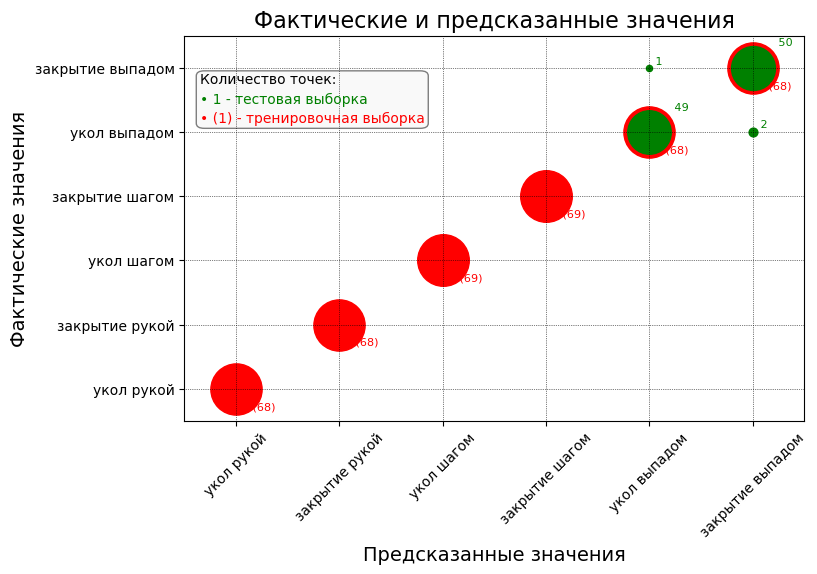

In [127]:
evaluate_preds(y_test_endurance, y_train_endurance, y_pred_endurance, y_train_pred_endurance, unique_movements, save = save)

# Анализ данных о ЧСС

In [129]:
# import xml.etree.ElementTree as ET

# tree = ET.parse('activity_14419481147.tcx')
# root = tree.getroot()

# hr_data = []

# namespace = {'ns': 'http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2'}

# for tp in root.findall('.//ns:Trackpoint', namespace):
#     hr_elem = tp.find('.//ns:HeartRateBpm/ns:Value', namespace)
#     if hr_elem is not None:
#         hr_data.append(int(hr_elem.text))
# hr_df = pd.DataFrame(hr_data, columns=['HeartRate'])

hr_df = pd.read_excel('hr.xlsx', sheet_name='Sheet1')

### График ЧСС при 3 подходах

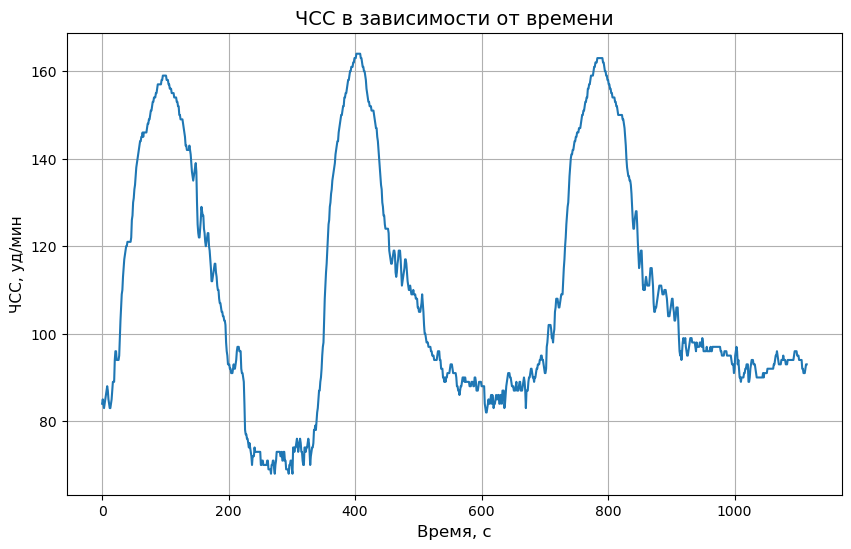

In [131]:
plt.figure(figsize=(10, 6))
plt.plot(hr_df.index, hr_df)
plt.title('ЧСС в зависимости от времени', fontsize=14)
plt.xlabel('Время, с', fontsize=12)
plt.ylabel('ЧСС, уд/мин', fontsize=11)
plt.grid(True)
if save == True:
    plt.savefig(f'ЧСС.png', dpi=400, bbox_inches='tight')
plt.show()

### Разделение всего сигнала на 3 подхода

In [133]:
# Сглаживание полиномом
def smoothed_df(hr_df):
    x = hr_df.index
    y = hr_df['HeartRate'].values

    coefficients = np.polyfit(x, y, 3)
    polynomial = np.poly1d(coefficients)

    smoothed_values = polynomial(x)
    smoothed_df = pd.DataFrame(smoothed_values)
    
    return smoothed_df

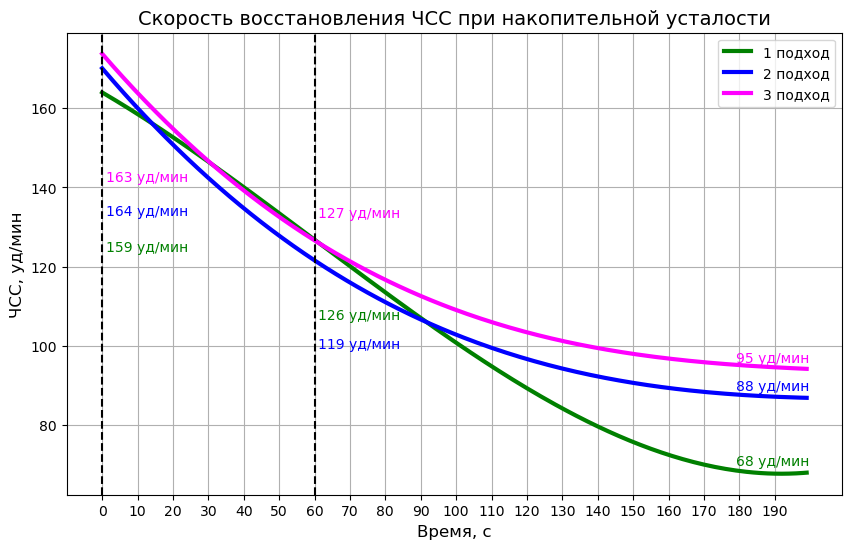

In [134]:
max1 = hr_df.iloc[50:200].idxmax()[0]
max2 = hr_df.iloc[300:500].idxmax()[0]
max3 = hr_df.iloc[700:900].idxmax()[0]

df1 = hr_df.iloc[max1:max1+250].reset_index(drop=True)
df2 = hr_df.iloc[max2:max2+250].reset_index(drop=True)
df3 = hr_df.iloc[max3:max3+250].reset_index(drop=True)

smoothed_df_1 = smoothed_df(df1).iloc[0:200]
smoothed_df_2 = smoothed_df(df2).iloc[0:200]
smoothed_df_3 = smoothed_df(df3).iloc[0:200]

plt.figure(figsize=(10, 6))
plt.plot(smoothed_df_1.index, smoothed_df_1, color='green', linewidth=3, label='1 подход')
plt.plot(smoothed_df_2.index, smoothed_df_2, color='blue', linewidth=3, label='2 подход')
plt.plot(smoothed_df_3.index, smoothed_df_3, color='fuchsia', linewidth=3, label='3 подход')

plt.axvline(x=0, color='black', linestyle='--')
plt.axvline(x=60, color='black', linestyle='--')

plt.text(1, smoothed_df_1.iloc[0, 0]-41, f'{df1.iloc[0, 0]:.0f} уд/мин', color='green', verticalalignment='bottom', horizontalalignment='left', fontsize=10)
plt.text(1, smoothed_df_2.iloc[0, 0]-38, f'{df2.iloc[0, 0]:.0f} уд/мин', color='blue', verticalalignment='bottom', horizontalalignment='left', fontsize=10)
plt.text(1, smoothed_df_3.iloc[0, 0]-33, f'{df3.iloc[0, 0]:.0f} уд/мин', color='fuchsia', verticalalignment='bottom', horizontalalignment='left', fontsize=10)

plt.text(61, smoothed_df_1.iloc[60, 0]-21, f'{df1.iloc[60, 0]:.0f} уд/мин', color='green', verticalalignment='bottom', horizontalalignment='left', fontsize=10)
plt.text(61, smoothed_df_2.iloc[60, 0]-23, f'{df2.iloc[60, 0]:.0f} уд/мин', color='blue', verticalalignment='bottom', horizontalalignment='left', fontsize=10)
plt.text(61, smoothed_df_3.iloc[60, 0]+5, f'{df3.iloc[60, 0]:.0f} уд/мин', color='fuchsia', verticalalignment='bottom', horizontalalignment='left', fontsize=10)

plt.text(max(smoothed_df_1.index)-20, smoothed_df_1.iloc[max(smoothed_df_1.index), 0]+1, f'{df1.iloc[max(smoothed_df_1.index), 0]:.0f} уд/мин', color='green', verticalalignment='bottom', horizontalalignment='left', fontsize=10)
plt.text(max(smoothed_df_2.index)-20, smoothed_df_2.iloc[max(smoothed_df_2.index), 0]+1, f'{df2.iloc[max(smoothed_df_2.index), 0]:.0f} уд/мин', color='blue', verticalalignment='bottom', horizontalalignment='left', fontsize=10)
plt.text(max(smoothed_df_3.index)-20, smoothed_df_3.iloc[max(smoothed_df_3.index), 0]+1, f'{df3.iloc[max(smoothed_df_3.index), 0]:.0f} уд/мин', color='fuchsia', verticalalignment='bottom', horizontalalignment='left', fontsize=10)

plt.title('Скорость восстановления ЧСС при накопительной усталости', fontsize=14)
plt.xlabel('Время, с', fontsize=12)
plt.ylabel('ЧСС, уд/мин', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(ticks=range(0, len(smoothed_df_1.index), 10))
if save:
    plt.savefig('Процесс восстановления ЧСС при накопительной усталости.png', dpi=400, bbox_inches='tight')
plt.show()

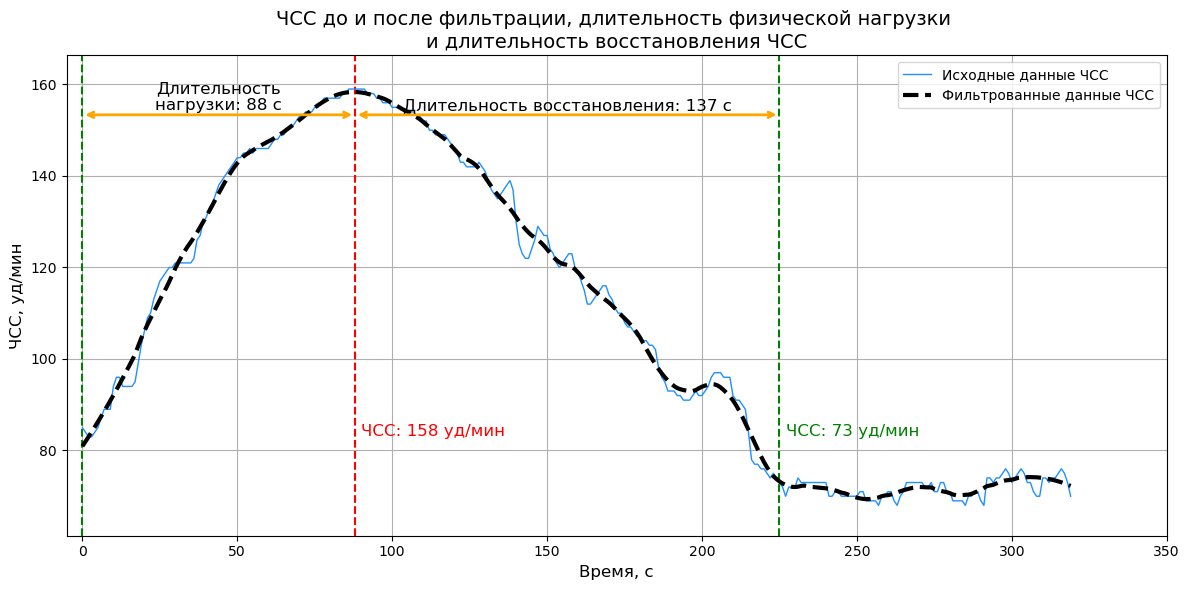

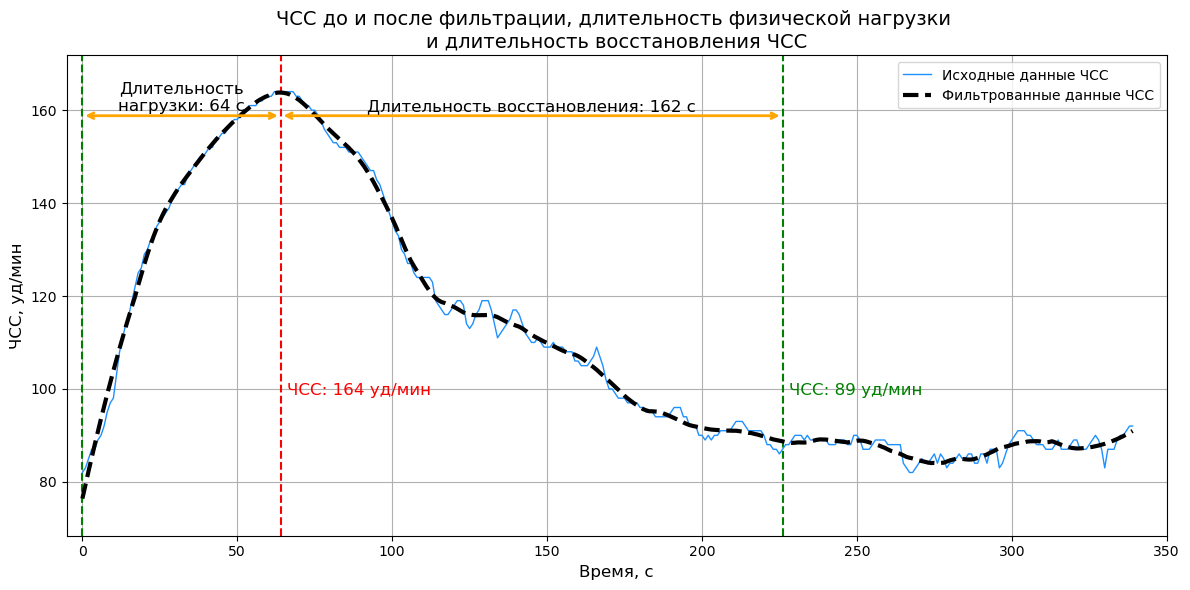

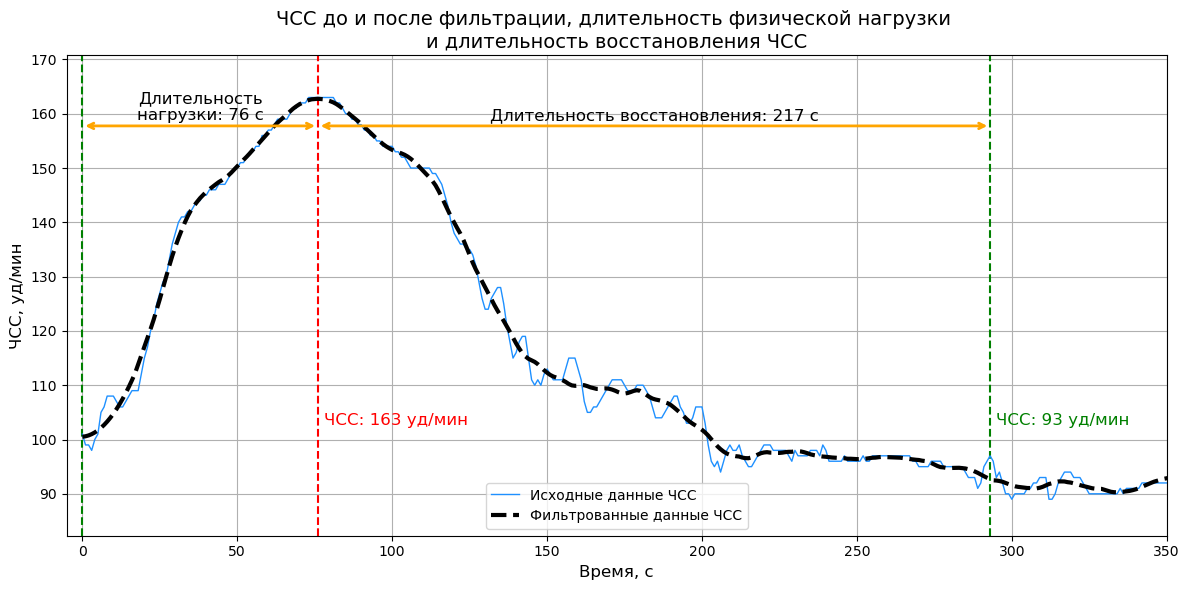

In [135]:
from scipy.signal import savgol_filter

def plot_filtered_heart_rate(dataframe, start_index, end_index, tol,  window_length, polyorder, save = False):
    df_filtered = dataframe.iloc[start_index:end_index].reset_index(drop=True)
    df_filtered_index = df_filtered.index
    
    # Сглаживание методом Савицкого-Голея к данным ЧСС
    filtered_hr = savgol_filter(df_filtered['HeartRate'], window_length=window_length, polyorder=polyorder)
    df_filtered['ЧСС_фильтрованный'] = filtered_hr
    
    # Индекс максимального значения в фильтрованных данных
    max_index = df_filtered['ЧСС_фильтрованный'].idxmax()
    
    # Определение начальной точки плато
    plateau_start = None
    for i in range(max_index + 1, len(df_filtered['ЧСС_фильтрованный'])):
        if df_filtered['ЧСС_фильтрованный'][i] + tol <= df_filtered['ЧСС_фильтрованный'][max_index]:
            plateau_start = i
            break
    
    # Время восстановления
    recovery_time_seconds = plateau_start - max_index
    
    plt.figure(figsize=(12, 6))

    # Вертикальные линии на месте начала подхода, на пике и на месте начала плато
    plt.axvline(x=0, color='green', linestyle='--') 
    plt.axvline(x=max_index, color='red', linestyle='--')
    plt.axvline(x=plateau_start, color='green', linestyle='--')
    
    # Линия с двумя стрелками и подписываем время восстановления
    plt.annotate('', xy=(max_index, df_filtered['ЧСС_фильтрованный'][max_index] - 5), 
                 xytext=(plateau_start, df_filtered['ЧСС_фильтрованный'][max_index] - 5),
                 arrowprops=dict(arrowstyle='<->', color='orange', lw=2))
    plt.text(max_index + (plateau_start - max_index) / 2, df_filtered['ЧСС_фильтрованный'][max_index] - 4,
             f'Длительность восстановления: {recovery_time_seconds:} с', color='black', 
             fontsize=12, horizontalalignment='center')
    
    # Линия с двумя стрелками и подписываем время длительности подхода
    plt.annotate('', xy=(0, df_filtered['ЧСС_фильтрованный'][max_index] - 5), 
                 xytext=(max_index, df_filtered['ЧСС_фильтрованный'][max_index] - 5),
                 arrowprops=dict(arrowstyle='<->', color='orange', lw=2))
    plt.text(max_index / 2, df_filtered['ЧСС_фильтрованный'][max_index] - 4,
             f'Длительность\nнагрузки: {max_index:} с', color='black', 
             fontsize=12, horizontalalignment='center')
    
    # Добавление надписей с ЧСС
    plt.text(plateau_start + 2, df_filtered['ЧСС_фильтрованный'].loc[plateau_start] + 10, 
             f'ЧСС: {df_filtered["ЧСС_фильтрованный"].loc[plateau_start]:.0f} уд/мин', color='green', 
             fontsize=12, horizontalalignment='left')
    plt.text(max_index + 2, df_filtered['ЧСС_фильтрованный'].loc[plateau_start] + 10, 
             f'ЧСС: {df_filtered["ЧСС_фильтрованный"].loc[max_index]:.0f} уд/мин', color='red', 
             fontsize=12, horizontalalignment='left')
    
    plt.plot(df_filtered_index, df_filtered['HeartRate'], label='Исходные данные ЧСС', color='dodgerblue', linewidth=1)
    plt.plot(df_filtered_index, df_filtered['ЧСС_фильтрованный'], label='Фильтрованные данные ЧСС', linestyle='--', color='black', linewidth=3)
    
    plt.xlim(-5, 350)
    plt.ylim(min(df_filtered['ЧСС_фильтрованный'])-8, max(df_filtered['ЧСС_фильтрованный'])+8)
    plt.title('ЧСС до и после фильтрации, длительность физической нагрузки \nи длительность восстановления ЧСС', fontsize=14)
    plt.xlabel('Время, с', fontsize=12)
    plt.ylabel('ЧСС, уд/мин', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if save == True:
        plt.savefig(f'ЧСС до и после фильтрации {start_index}.png', dpi=400, bbox_inches='tight')
    plt.show()
    
    return df_filtered, recovery_time_seconds


ranges = [[85, 10, 330], [75, 340, 680], [70, 710, 1115]]
filtered_hr_dfs = []
recovery_times = []

for tol, start_index, end_index in ranges:
    filtered_hr_df, recovery_time = plot_filtered_heart_rate(hr_df, start_index, end_index, tol, window_length=35, polyorder=2, save=save)
    filtered_hr_dfs.append(filtered_hr_df)
    recovery_times.append(recovery_time)

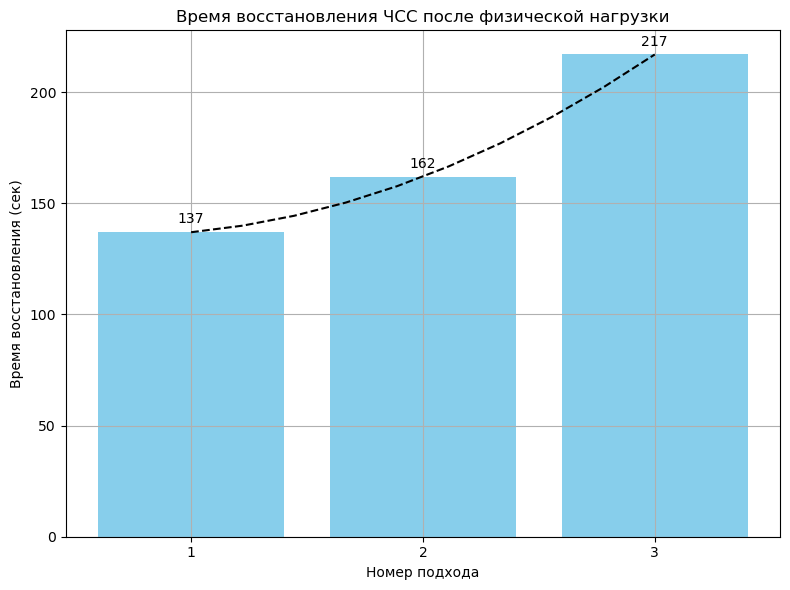

In [136]:
time_coefficients = np.polyfit(range(len(recovery_times)), recovery_times, 2)
time_polynomial = np.poly1d(time_coefficients)
time_smoothes_x = np.linspace(0, len(recovery_times)-1, 10)
time_smoothes_y = time_polynomial(time_smoothes_x)

plt.figure(figsize=(8, 6))
plt.bar(range(len(recovery_times)), recovery_times, color='skyblue')
plt.plot(time_smoothes_x, time_smoothes_y, linestyle='--', color='black')
plt.xlabel('Номер подхода')
plt.ylabel('Время восстановления (сек)')
plt.title('Время восстановления ЧСС после физической нагрузки')
for i, time in enumerate(recovery_times):
    plt.text(i, time + 4, f'{time}', ha='center')
plt.xticks(range(len(recovery_times)), ['1', '2', '3'])
plt.tight_layout()
plt.grid(True)
if save == True:
    plt.savefig('Время восстановления ЧСС после физической нагрузки.png', dpi=400, bbox_inches='tight')
plt.show()

# Оценка параметров движения

## Длительность движения

In [139]:
def plot_timing_line(timing_1, timing_2, label1, label2, save=False):
    plt.figure(figsize=(12, 6))
    bins = np.arange(0.5, 1.2, 0.05)
    plt.plot(range(len(timing_1)), timing_1, label=label1, color='blue')
    plt.plot(range(len(timing_2)), timing_2, label=label2, color='red')
    
    plt.axvline(x=26.5, color='black', linestyle='--', linewidth=2)
    plt.annotate('подход №1', xy=(13.5, min(timing_1)), xytext=(13.5, min(timing_1)-0.05),
                 color='black', fontsize=12, ha='center',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    plt.annotate('подход №3', xy=(39.5, min(timing_1)), xytext=(39.5, min(timing_1)-0.05),
                 color='black', fontsize=12, ha='center',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
    plt.ylim(0.75, 1.45)
    plt.title('Длительность движения', fontsize=14)
    plt.xlabel('Номер движения', fontsize=12)
    plt.ylabel('Время, с', fontsize=12)
    plt.legend()
    plt.grid(True)
    if save == True:
        plt.savefig(f'Длительность движений лин усталось {label1, len(timing_1)}.png', dpi=400, bbox_inches='tight')
    plt.show()

In [140]:
timing_1 = []
timing_2 = []

for s in range(0, len(All_signs_endurance), 2):
    timing_1.append(All_signs_endurance.iloc[s]['Отсчеты_x_груди'] / fs)
for s in range(1, len(All_signs_endurance), 2):
    timing_2.append(All_signs_endurance.iloc[s]['Отсчеты_x_груди'] / fs)

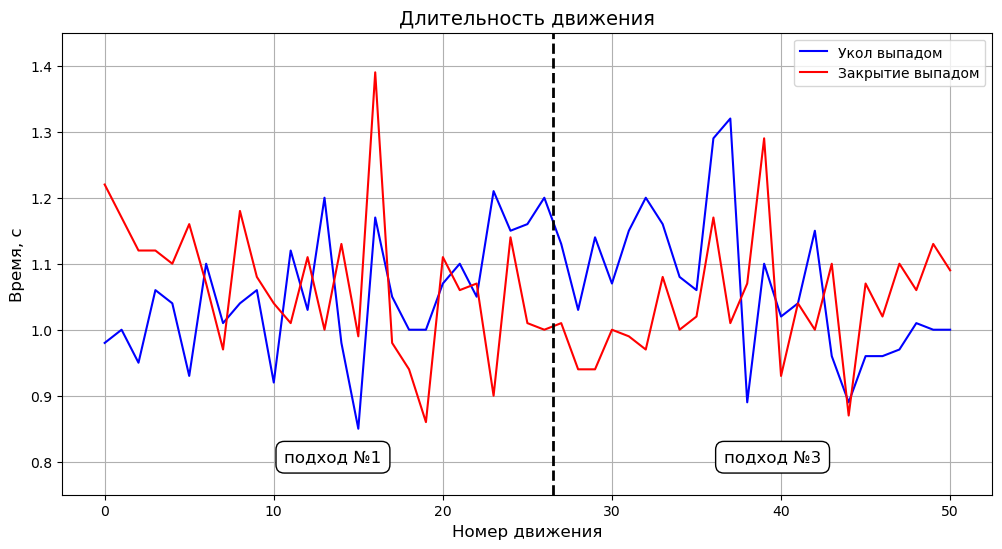

In [141]:
plot_timing_line(timing_1, timing_2, 'Укол выпадом', 'Закрытие выпадом', save=save)

In [142]:
def plot_timing(timing_1, timing_2, label1, label2, save=False):
    plt.figure(figsize=(12, 6))
    bins = np.arange(min(timing_1)-0.1, max(timing_2)+0.1, 0.05)
    plt.hist(timing_1, bins=bins, alpha=0.5, label=label1, color='blue')
    plt.hist(timing_2, bins=bins, alpha=0.5, label=label2, color='red')
    plt.title('Длительность движения')
    plt.xlabel('Длительность, с')
    plt.ylabel('Количество движений')
    plt.legend()
    plt.grid(True)
    if save == True:
        plt.savefig(f'Длительность движений столбч усталость {label1, len(timing_1)}.png', dpi=400, bbox_inches='tight')
    plt.show()

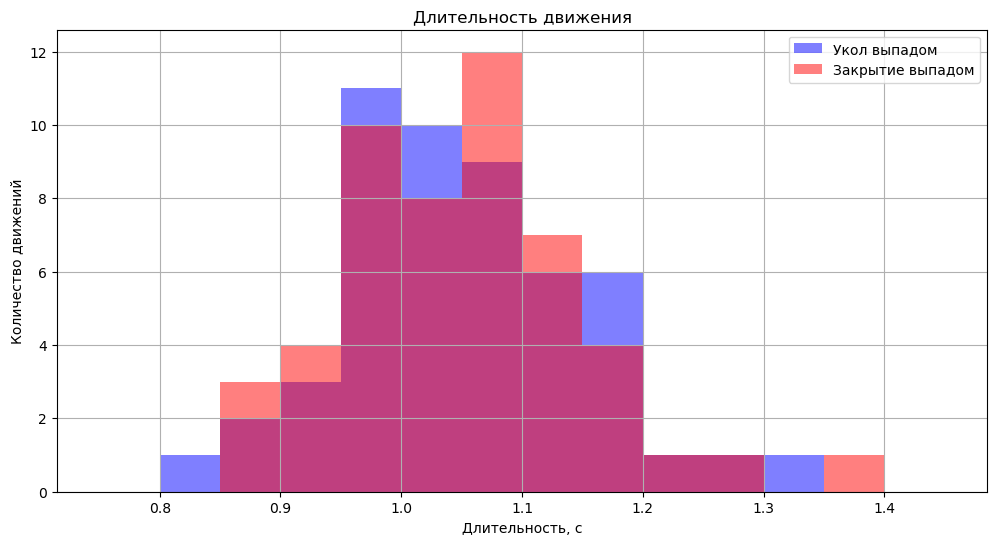

In [143]:
plot_timing(timing_1, timing_2, 'Укол выпадом', 'Закрытие выпадом', save=save)

## Соотношение типов движений во время боя

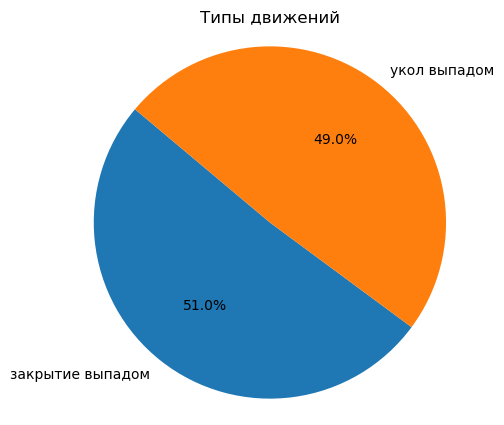

In [145]:
unique, counts = np.unique(y_pred_endurance, return_counts=True)
movement_counts = dict(zip(unique, counts))

plt.figure(figsize=(5, 5))
plt.pie(counts, labels=unique, autopct='%1.1f%%', startangle=140)
plt.title('Типы движений')
plt.axis('equal') 
plt.grid(True)
if save == True:
    plt.savefig('Типы движений круг усталость.png', dpi=300, bbox_inches='tight')
plt.show()

# Анализ данных акселерометра

In [147]:
def accel_average(all_movement_dfs_accel, all_movement_dfs):
    for list_df in all_movement_dfs_accel:
        for df in list_df:
            df.rename(columns={'x': 'x_accel', 'y': 'y_accel','z': 'z_accel'}, inplace=True)
            df.drop(columns='t',  inplace = True)
            df.reset_index(drop=True, inplace = True)
            
    for list_df in all_movement_dfs:
        for df in list_df:
            df.reset_index(drop=True, inplace = True)
            
    merged_dfs = []
    for movement_list, accel_list in zip(all_movement_dfs, all_movement_dfs_accel):
        temp_merged_dfs = []
        for movement_df, accel_df in zip(movement_list, accel_list):
            merged_df = pd.merge(movement_df, accel_df, left_index=True, right_index=True)
            temp_merged_dfs.append(merged_df)
        merged_dfs.append(temp_merged_dfs)
    
    concatenated_dfs = []
    for i, merged_df in enumerate(merged_dfs):
        x_accel_dfs = [merged_dfs[i][1]['x_accel']]
        concatenated_df = pd.concat(x_accel_dfs, axis=1)
        concatenated_dfs.append(concatenated_df)

    merged_df = pd.concat(concatenated_dfs, axis=1)
    average_df = merged_df.mean(axis=1)
    result_df = pd.DataFrame({'x_accel': average_df})
    
    average_length = int(sum(len(df) for df in concatenated_dfs) / len(concatenated_dfs))
    result_df = result_df.iloc[:average_length]
    
    return merged_dfs, result_df


def plot_accel(df, fs, way_lunge, ylabel, savefig_name, i='', save=False):
    time = np.arange(len(df)) / fs
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 10))
    axes[0].plot(time, df['x_accel'], color='limegreen', label='Ускорение', linewidth=2)
    axes[0].set_ylabel('Ускорение, g', fontsize=14)
    axes[1].plot(time, df['x_speed'], color='blue', label='Скорость', linewidth=2)
    axes[1].set_ylabel('Скорость, см/с', fontsize=14)
    axes[2].plot(time, df['x_amplitude'], color='red', label=ylabel, linewidth=2)
    axes[2].set_ylabel(ylabel, fontsize=14)
    fig.suptitle(f'Данные акселерометра. Движение: {way_lunge} {i}', fontsize=16)
    axes[2].set_xlabel('Время, c', fontsize=14)
    for ax in axes:
        ax.grid(which='major', linewidth=0.5, linestyle=':', color='k')
        ax.legend()
    if save:
        plt.savefig(f'{savefig_name}.png', dpi=400, bbox_inches='tight')
    plt.tight_layout()
    plt.show()
    plt.close()


def integr(result_df):
    result_df['x_speed'] = result_df['x_accel'].cumsum()
    result_df['x_amplitude'] = result_df['x_speed'].cumsum()
    return result_df

In [148]:
merged_dfs_forward, result_df_forward = accel_average(all_movement_dfs_accel_forvard, all_movement_dfs_forvard)

# Среднее ускорение, скорость и амлитуда выпада

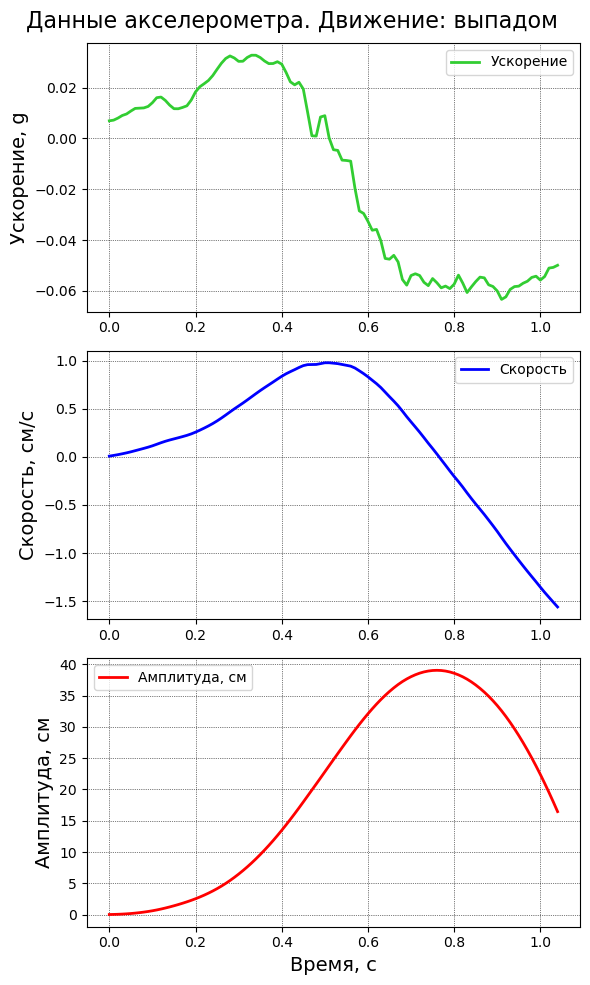

In [150]:
result_df_forward_all = integr((result_df_forward)*9.81/100)
plot_accel(result_df_forward_all, fs, way_lunge='выпадом', savefig_name='Средняя скорость руки при выпаде', ylabel = 'Амплитуда, см', save=save)

# Максимальные скорости и перемещения для всех выпадов 

In [152]:
def process_merged_dfs(merged_dfs_forward, fs):
    max_speeds = []
    max_amplitudes = []
    movement_numbers = []
    action_executed = False

    for j in range(len(merged_dfs_forward)):
        df = merged_dfs_forward[j][0]
        result_df = df.copy()
        result_df['x_accel'] = (df['x_accel']) * 9.81 / 100
        result_df = integr(result_df)
        
        max_speed = result_df['x_speed'].max()
        max_amplitude = result_df['x_amplitude'].max()
        
        max_speeds.append(max_speed)
        max_amplitudes.append(max_amplitude)
        movement_numbers.append(j+1)
        
        if not action_executed:
            plot_accel(result_df, fs, way_lunge='выпадом', i=f'№{j+1}', ylabel = 'Длина, см', savefig_name=f'Выпад {j}', save=save)
            action_executed = True
       
    return max_speeds, max_amplitudes, movement_numbers

    
def plot_max_values(movement_numbers, max_speeds, max_amplitudes):
    fig, ax1 = plt.subplots(figsize=(12, 8))

    # График для максимальной скорости
    ax1.set_xlabel('Номер движения', fontsize=14)
    ax1.set_ylabel('Максимальная скорость, см/с', color='tab:orange', fontsize=14)
    ax1.plot(movement_numbers, max_speeds, color='tab:orange', marker='o', label='Максимальная скорость')
    ax1.tick_params(axis='y', labelcolor='tab:orange', labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.set_xticks(movement_numbers)
    ax1.set_xticklabels(movement_numbers, fontdict={'fontsize': 10})
    ax1.grid(True, which='both', axis='y', linestyle='-', linewidth=0.5, color='orange')
    ax1.grid(True, which='both', axis='x', linestyle='-', linewidth=0.5, color='grey')
    
    # График для максимальной амплитуды
    ax2 = ax1.twinx()
    ax2.set_ylabel('Амплитуда, см', color='tab:green', fontsize=14)
    ax2.plot(movement_numbers, max_amplitudes, color='tab:green', marker='o', label='Амплитуда')
    ax2.tick_params(axis='y', labelcolor='tab:green', labelsize=12)
    ax2.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, color='green')

    # Добавление вертикальной линии и подписей
    ax2.axvline(x=26.5, color='black', linestyle='--', linewidth=2)
    ax2.annotate('подход №1', xy=(13.5, max(max_amplitudes)), xytext=(13.5, max(max_amplitudes)-2),
                 color='black', fontsize=16, ha='center',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    ax2.annotate('подход №3', xy=(39.5, max(max_amplitudes)), xytext=(39.5, max(max_amplitudes)-2),
                 color='black', fontsize=16, ha='center',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    fig.suptitle('Максимальная скорость и амплитуда в зависимости от номера движения', fontsize=20)
    fig.tight_layout()
    plt.savefig('Максимальные значения скорости и амплитуды.png', dpi=400, bbox_inches='tight')

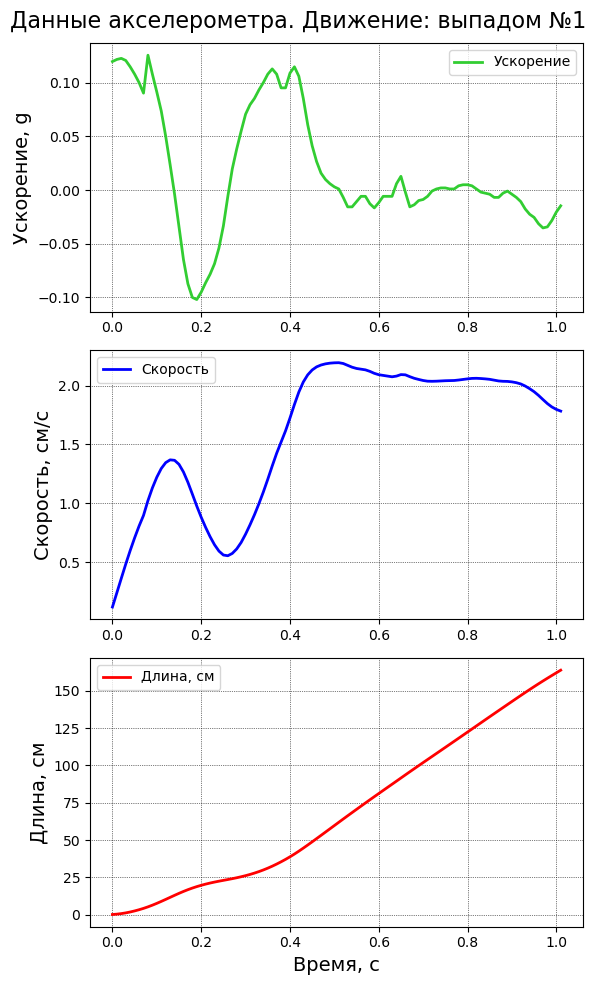

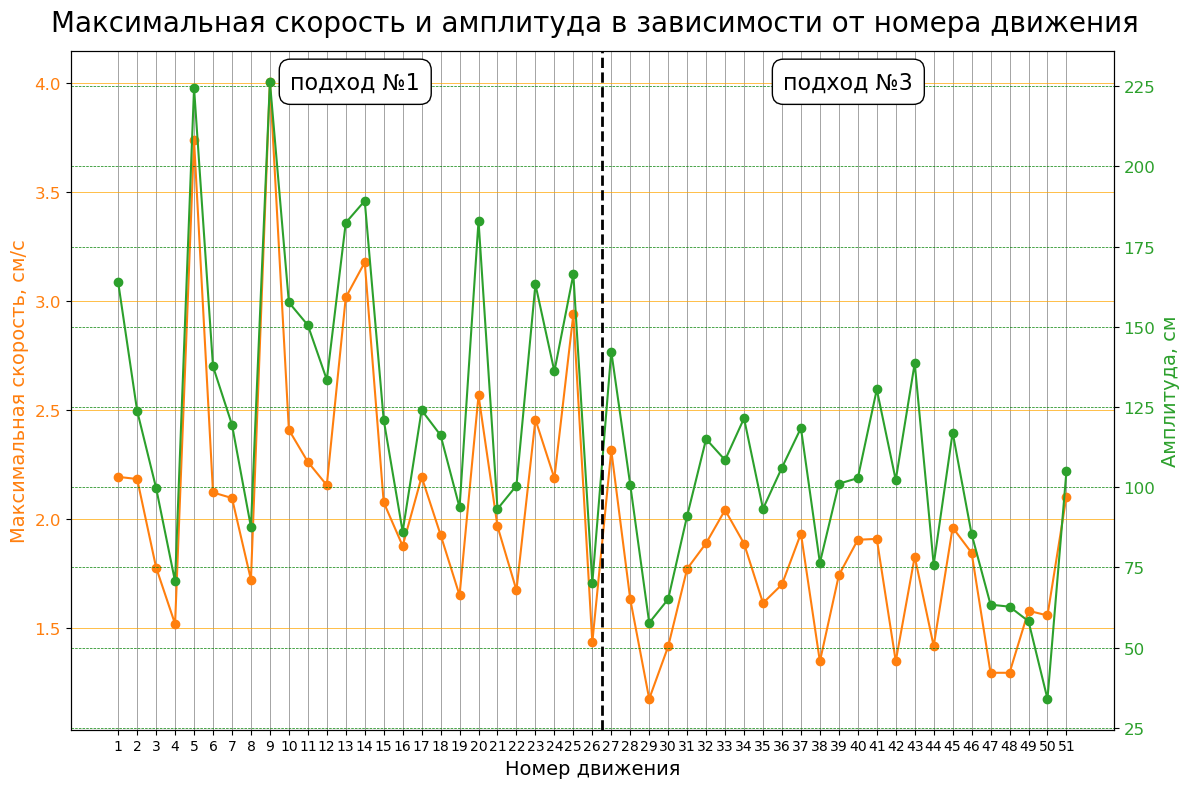

In [153]:
max_speeds, max_amplitudes, movement_numbers = process_merged_dfs(merged_dfs_forward, fs)

plot_max_values(movement_numbers, max_speeds, max_amplitudes)

In [154]:
def median_param(max_par, n):
    smoothed = []
    for i in range(0, len(max_par), n):
        m_value = np.mean(max_par[i:i+n])
        smoothed.extend([m_value] * (n+1))
    return smoothed


def plot_speed_ampl(smoothed, title, ylabel, n, c, save=False):
    plt.figure(figsize=(6, 4))

    plt.plot(range(n), smoothed[:n], color='green', linewidth=2, label='подход №1')
    plt.text(n/2, smoothed[0]-c, f'{round(smoothed[0], 1)}', ha='center', va='top', fontsize=10, color='green')
    
    plt.plot(range(n+1, len(smoothed)), smoothed[n+1:], color='red', linewidth=2, label='подход №3')
    plt.text(n + (len(smoothed) - n)/2, smoothed[n+1]+c, f'{round(smoothed[n+1], 1)}', ha='center', va='bottom', fontsize=10, color='red')

    plt.title(f'Изменение средней {title} при накопительной усталости')
    plt.xlabel('Номер движения')
    plt.ylabel(ylabel)
    plt.legend()
    plt.axvline(x=n, color='black', linestyle='--', linewidth=2)
    plt.grid(True)
    if save == True:
        plt.savefig(f'Изменение {title} при накопительной усталости.png', dpi=400, bbox_inches='tight')
    plt.show()

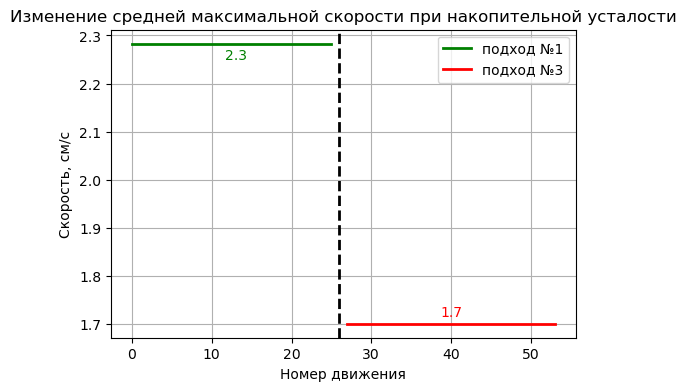

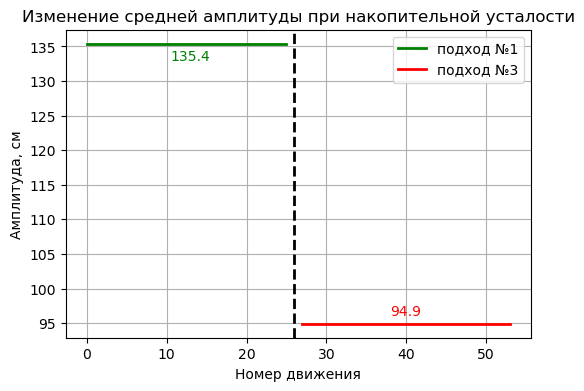

In [211]:
smoothed_speed = median_param(max_speeds, 26)
smoothed_amplitude = median_param(max_amplitudes, 26)


plot_speed_ampl(smoothed_speed, 'максимальной скорости', ylabel='Скорость, см/с', n=26, c=0.01, save=save)
plot_speed_ampl(smoothed_amplitude, 'амплитуды', ylabel='Амплитуда, см', n=26, c=0.75, save=save)